### Задание

Музыкальный стриминговый сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Описание полей данных
- ***instance_id*** - уникальный идентификатор трека
- ***track_name*** - название трека
- ***acousticness*** - акустичность
- ***danceability*** - танцевальность
- ***duration_ms*** - продолжительность в милисекундах
- ***energy*** - энергичность
- ***instrumentalness*** - инструментальность
- ***key*** - базовый ключ (нота) произведения
- ***liveness*** - привлекательность
- ***loudness*** - громкость
- ***mode*** - указывает на модальность (мажорную или минорную) трека
- ***speechiness*** - выразительность
- ***tempo*** - темп
- ***obtained_date*** - дата загрузки в сервис
- ***valence*** - привлекательность произведения для пользователей сервиса
- ***music_genre*** - музыкальный жанр

# [Оглавление](#section_0)<br>
[1. Импорты и настройки](#section_1)<br>
[2. Загрузка данных и EDA](#section_2)<br>
- [2.1. Предобработка и добавление синтетических признаков.](#section_2.1)<br>
- [2.2. Подготовка пайплайна и подбор гиперпараметров моделей.](#section_2.2)<br>

[3. Поиск лучшей модели](#section_6)<br>
[4. Проверка лучшей модели](#section_7)<br>
[5. Выводы](#section_8)<br>

[К оглавлению](#section_0)
<a id='section_1'></a>
# Импорты и настройки

In [2]:
import warnings

import numpy as np
import optuna
import pandas as pd
import phik
import shap
import sweetviz as sv

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from optuna.samplers import TPESampler
from phik.report import plot_correlation_matrix
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

RANDOM_STATE = 1

In [3]:
# настройки
pd.options.display.float_format = '{:_.4f}'.format
pd.options.display.max_columns = None
warnings.filterwarnings("ignore")

In [4]:
def get_data_info(data: pd.DataFrame) -> None:
    '''
    Функция для изучения полученных данных. 
    
    Args:
        data: датафрейм
    '''
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))
    print(f'Количество пропусков в данных: \n{data.isna().sum().sort_values(ascending=False)}')
    print(f'Кол-во дубликатов в данных = {data.duplicated().sum()}')

[К оглавлению](#section_0)
<a id='section_2'></a>
# Загрузка данных и EDA

In [10]:
try:
    df_train = pd.read_csv('kaggle_music_genre_train.csv')
    df_test = pd.read_csv('kaggle_music_genre_test.csv')
    
except:
    df_train = pd.read_csv('/datasets/kaggle_music_genre_train.csv')
    df_test = pd.read_csv('/datasets/kaggle_music_genre_test.csv')

In [11]:
get_data_info(df_train)

instance_id                     track_name  acousticness  danceability  \
1915   28_961.0000  Doctor Doctor - 2007 Remaster        0.0002        0.2980   
18791  36_061.0000                  Great Release        0.1670        0.6020   
14979  44_789.0000            Baby Can I Hold You        0.0811        0.6920   
16936  37_815.0000                    Budos Theme        0.0294        0.4350   
12923  87_700.0000                        Catwalk        0.8770        0.7390   

       duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
1915  252_453.0000  0.7990            0.0001   D    0.4960   -6.9620  Minor   
18791 395_120.0000  0.8500            0.9520   G    0.0985  -10.8430  Major   
14979 193_120.0000  0.4220            0.0000   D    0.0848  -10.5330  Major   
16936 189_040.0000  0.8730            0.7770   F    0.1080   -6.0030  Minor   
12923 248_627.0000  0.4470            0.7710   A    0.0802   -8.5710  Minor   

       speechiness    tempo obtained_date  valence music_genre  
1915        0.0464 143.0720         4-Apr   0.5610       Blues  
18791       0.0540 131.9910         4-Apr   0.0885  Electronic  
14979       0.0333  74.3750         4-Apr   0.4680        Rock  
16936       0.0770 119.3430         4-Apr   0.9630        Jazz  
12923       0.0566  90.0030         4-Apr   0.7580        Jazz

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

instance_id track_name  acousticness  danceability    duration_ms  \
count   20_394.0000      20394   20_394.0000   20_394.0000    20_394.0000   
unique          NaN      18643           NaN           NaN            NaN   
top             NaN       Home           NaN           NaN            NaN   
freq            NaN         11           NaN           NaN            NaN   
mean    55_973.8469        NaN        0.2748        0.5620   220_375.4253   
std     20_695.7925        NaN        0.3216        0.1719   126_728.3261   
min     20_011.0000        NaN        0.0000        0.0600        -1.0000   
25%     38_157.2500        NaN        0.0152        0.4510   177_517.0000   
50%     56_030.0000        NaN        0.1200        0.5700   219_533.0000   
75%     73_912.7500        NaN        0.4700        0.6830   266_000.0000   
max     91_758.0000        NaN        0.9960        0.9780 4_497_994.0000   

            energy  instrumentalness    key    liveness    loudness   mode  \
count  20_394.0000       20_394.0000  19659 20_394.0000 20_394.0000  19888   
unique         NaN               NaN     12         NaN         NaN      2   
top            NaN               NaN      G         NaN         NaN  Major   
freq           NaN               NaN   2304         NaN         NaN  12828   
mean        0.6253            0.1600    NaN      0.1985     -8.5530    NaN   
std         0.2512            0.3065    NaN      0.1667      5.4999    NaN   
min         0.0010            0.0000    NaN      0.0136    -44.4060    NaN   
25%         0.4700            0.0000    NaN      0.0973    -10.2557    NaN   
50%         0.6660            0.0001    NaN      0.1300     -7.0520    NaN   
75%         0.8300            0.0845    NaN      0.2530     -5.0540    NaN   
max         0.9990            0.9960    NaN      1.0000      3.7440    NaN   

        speechiness       tempo obtained_date     valence music_genre  
count   20_394.0000 19_952.0000         20394 20_394.0000       20394  
unique          NaN         NaN             4         NaN          10  
top             NaN         NaN         4-Apr         NaN       Blues  
freq            NaN         NaN         18435         NaN        2858  
mean         0.0914    120.9425           NaN      0.4646         NaN  
std          0.0977     30.4276           NaN      0.2434         NaN  
min          0.0223     34.7650           NaN      0.0000         NaN  
25%          0.0356     95.9218           NaN      0.2720         NaN  
50%          0.0490    120.0125           NaN      0.4570         NaN  
75%          0.0956    141.9663           NaN      0.6530         NaN  
max          0.9420    220.0410           NaN      0.9920         NaN

key                 735
mode                506
tempo               442
instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
liveness              0
loudness              0
speechiness           0
obtained_date         0
valence               0
music_genre           0
dtype: int64

'Кол-во дубликатов в данных = 0'

In [7]:
get_data_info(df_test)

instance_id                           track_name  acousticness  \
3404        52358                            The Dream        0.0000   
3141        75624                            Born Free        0.0064   
1316        74481                        Above The Law        0.1040   
4799        48904                            Wonderboy        0.0574   
2931        26668  Midnight Mischief - Tom Misch Remix        0.4920   

      danceability  duration_ms  energy  instrumentalness key  liveness  \
3404        0.1620 412_040.0000  0.9590            0.4750   C    0.2450   
3141        0.5920 264_533.0000  0.9170            0.0000   A    0.1120   
1316        0.4950 209_613.0000  0.8930            0.0000   B    0.1920   
4799        0.3900 246_867.0000  0.9140            0.0001   D    0.1080   
2931        0.5460 266_087.0000  0.4040            0.0269   G    0.1150   

      loudness   mode  speechiness    tempo obtained_date  valence  
3404   -5.2860  Minor       0.1320 193.1740         4-Apr   0.3900  
3141   -1.2780  Major       0.0275 127.4390         4-Apr   0.6820  
1316   -3.3310  Major       0.4490 183.4060         4-Apr   0.5110  
4799   -4.1430  Major       0.0759 104.2590         4-Apr   0.3440  
2931   -7.4410  Major       0.0353      NaN         4-Apr   0.0395

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


None

instance_id track_name  acousticness  danceability    duration_ms  \
count    5_099.0000       5099    5_099.0000    5_099.0000     5_099.0000   
unique          NaN       4981           NaN           NaN            NaN   
top             NaN  Hurricane           NaN           NaN            NaN   
freq            NaN          3           NaN           NaN            NaN   
mean    55_643.8713        NaN        0.2763        0.5619   217_397.4077   
std     20_762.3848        NaN        0.3227        0.1705   115_637.4083   
min     20_012.0000        NaN        0.0000        0.0596        -1.0000   
25%     37_571.0000        NaN        0.0166        0.4510   173_733.5000   
50%     55_246.0000        NaN        0.1200        0.5680   217_500.0000   
75%     73_702.0000        NaN        0.4600        0.6810   264_247.0000   
max     91_709.0000        NaN        0.9960        0.9770 1_360_027.0000   

           energy  instrumentalness   key   liveness   loudness   mode  \
count  5_099.0000        5_099.0000  4941 5_099.0000 5_099.0000   4950   
unique        NaN               NaN    12        NaN        NaN      2   
top           NaN               NaN     D        NaN        NaN  Major   
freq          NaN               NaN   557        NaN        NaN   3177   
mean       0.6220            0.1652   NaN     0.1979    -8.6302    NaN   
std        0.2518            0.3119   NaN     0.1662     5.6198    NaN   
min        0.0015            0.0000   NaN     0.0204   -46.1220    NaN   
25%        0.4650            0.0000   NaN     0.0969   -10.2310    NaN   
50%        0.6600            0.0002   NaN     0.1290    -7.1350    NaN   
75%        0.8260            0.0927   NaN     0.2480    -5.1270    NaN   
max        0.9990            0.9940   NaN     0.9900     1.9490    NaN   

        speechiness      tempo obtained_date    valence  
count    5_099.0000 4_978.0000          5099 5_099.0000  
unique          NaN        NaN             4        NaN  
top             NaN        NaN         4-Apr        NaN  
freq            NaN        NaN          4597        NaN  
mean         0.0927   121.2465           NaN     0.4656  
std          0.1001    29.8759           NaN     0.2442  
min          0.0226    37.1140           NaN     0.0205  
25%          0.0357    96.0702           NaN     0.2720  
50%          0.0487   120.0535           NaN     0.4580  
75%          0.0965   141.9343           NaN     0.6500  
max          0.9180   216.0290           NaN     0.9820

key                 158
mode                149
tempo               121
instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
liveness              0
loudness              0
speechiness           0
obtained_date         0
valence               0
dtype: int64

'Кол-во дубликатов в данных = 0'

In [8]:
# Установлю колонку с номером трека как индекс. 
df_train.instance_id = df_train.instance_id.astype(int)
df_train.set_index('instance_id', inplace=True)

                                             |          | [  0%]   00:00 -> (? left)


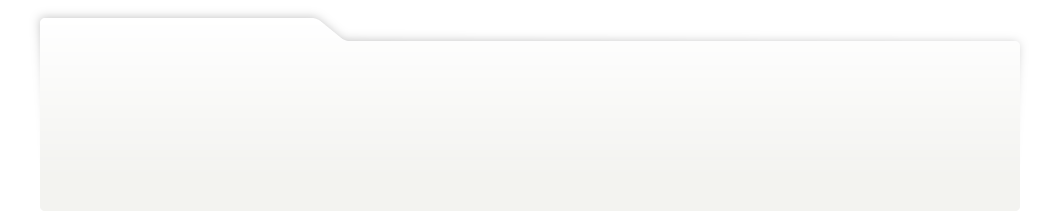
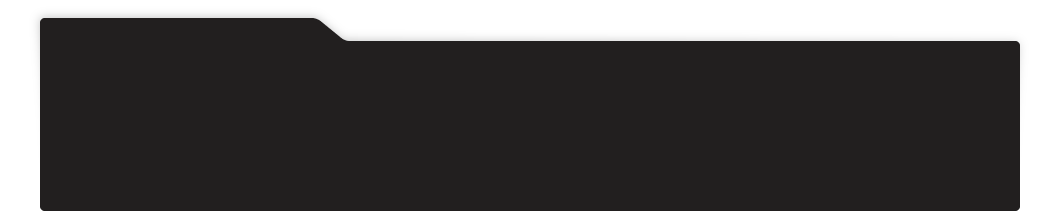
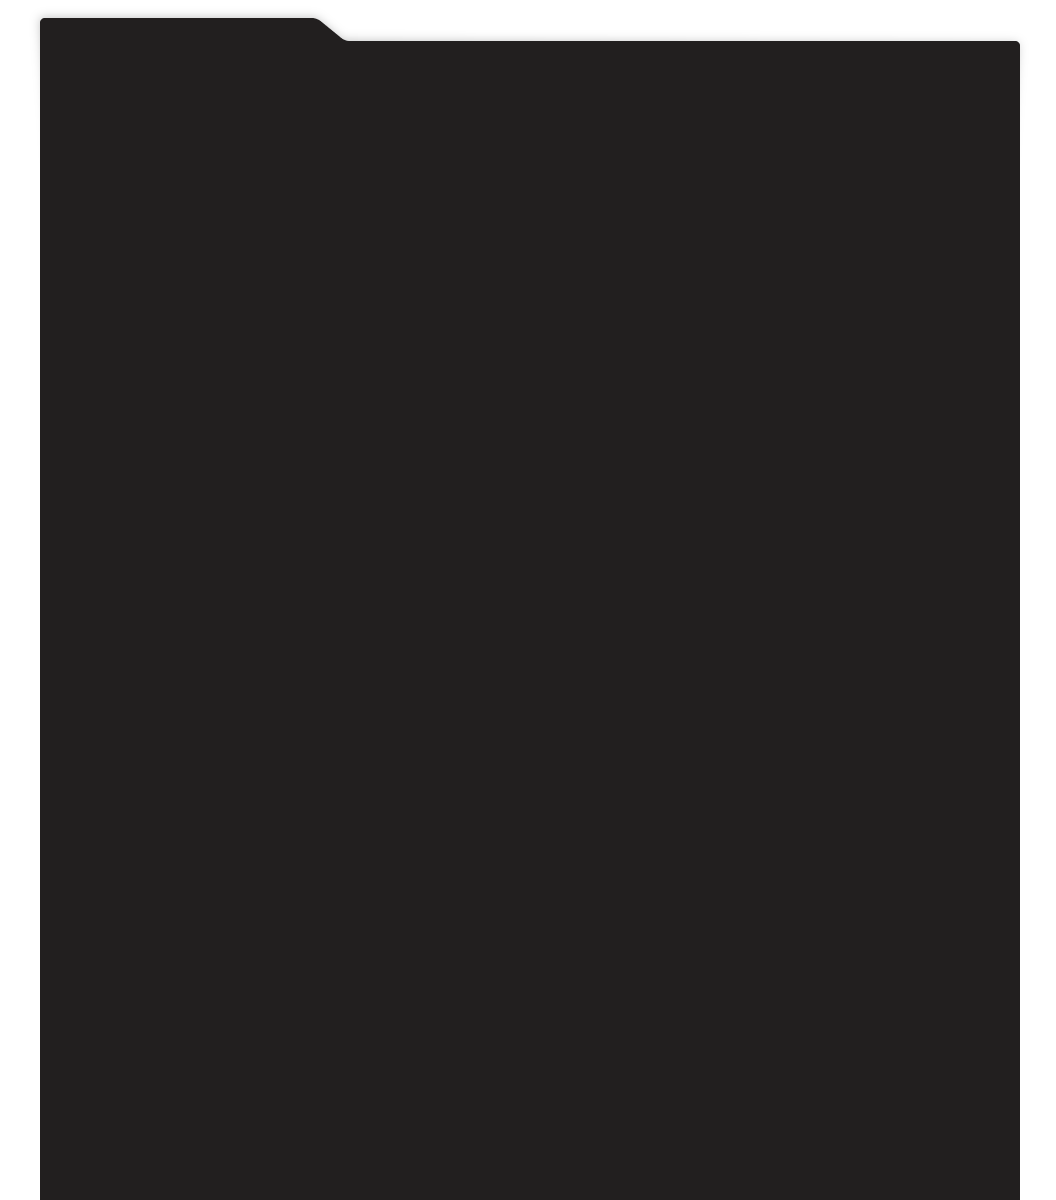
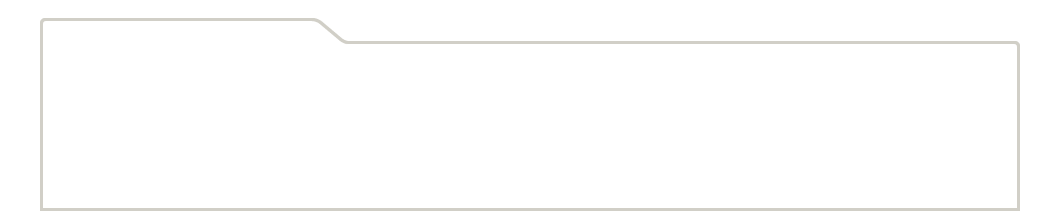
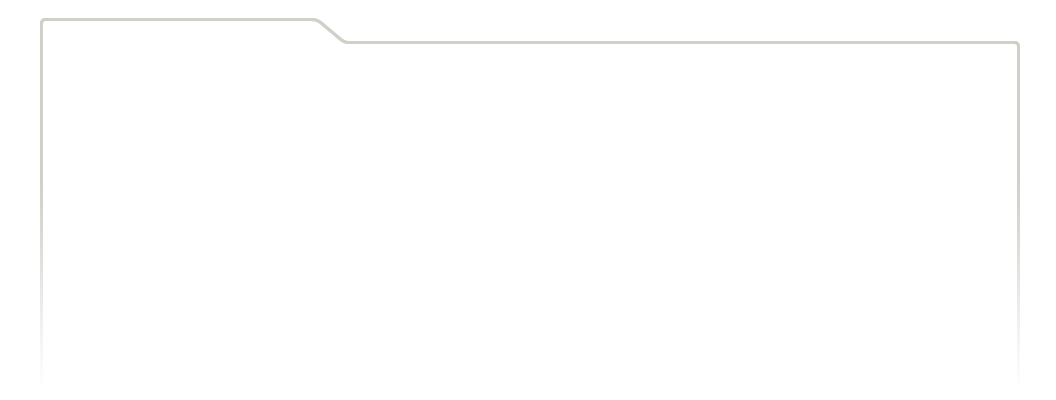
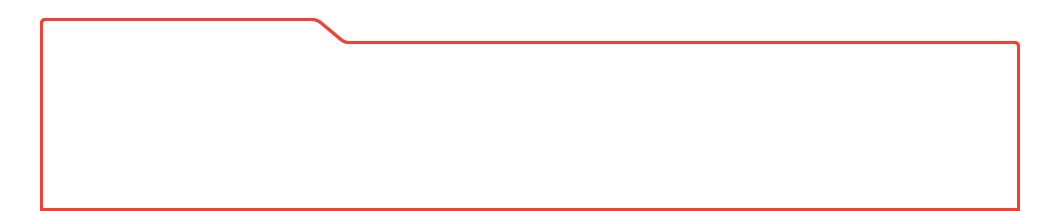
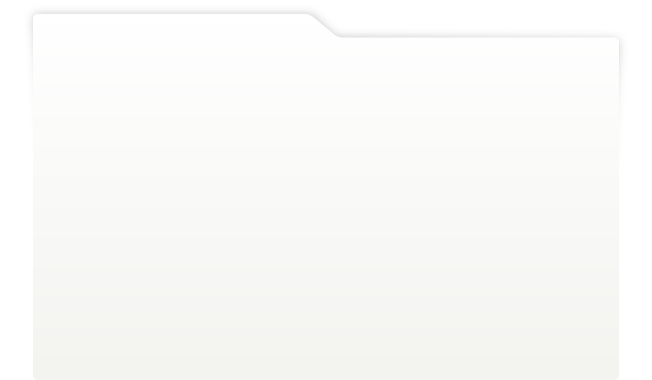
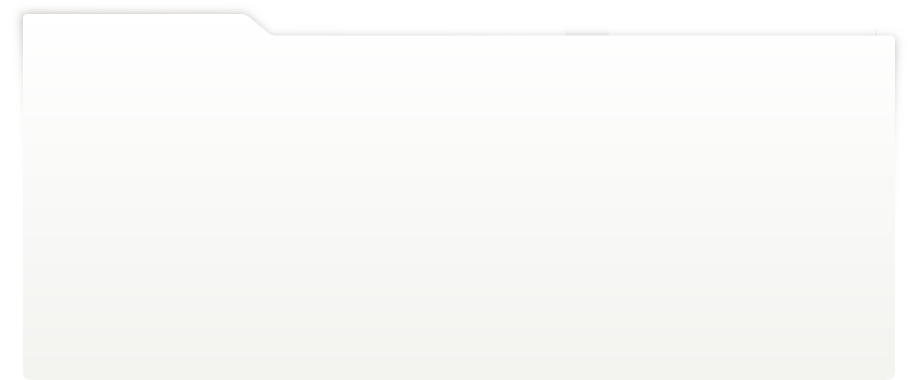
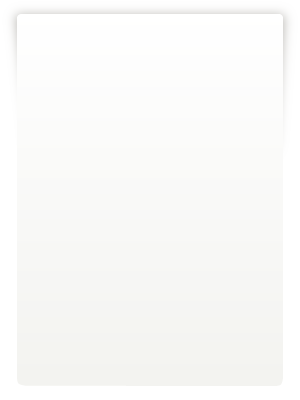
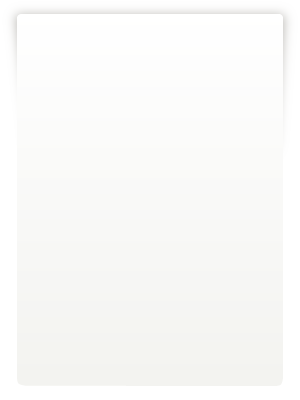
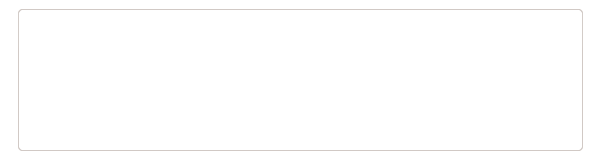
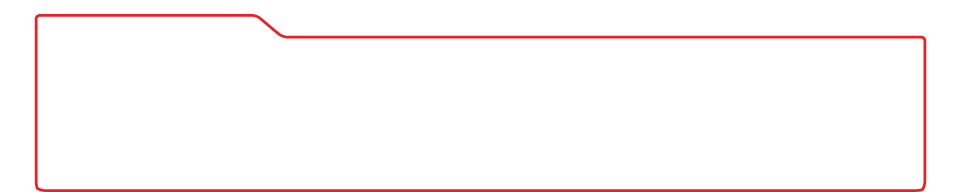
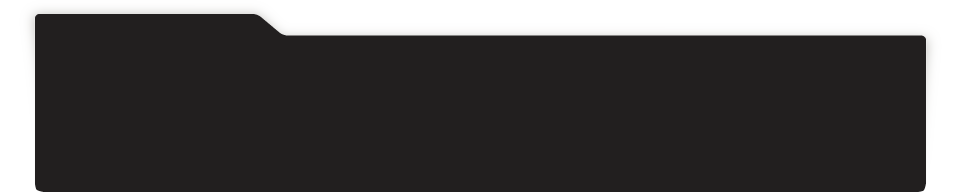
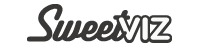
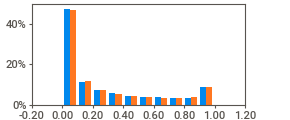
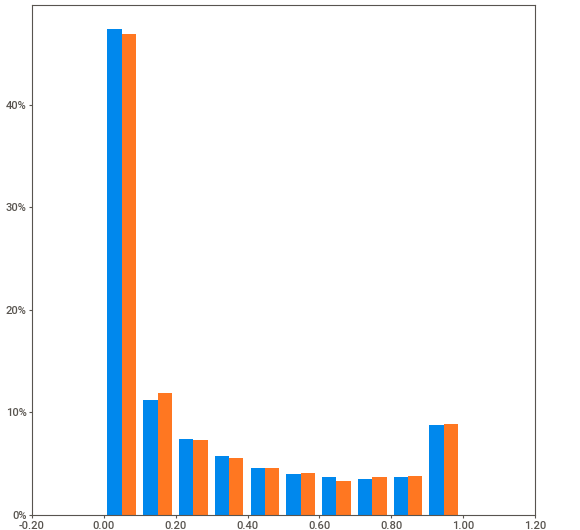
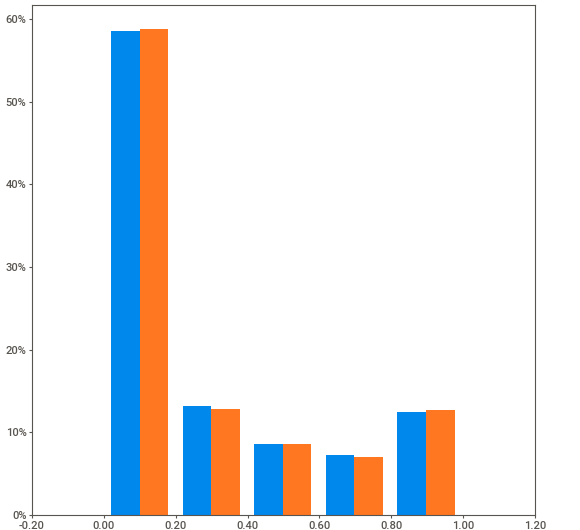
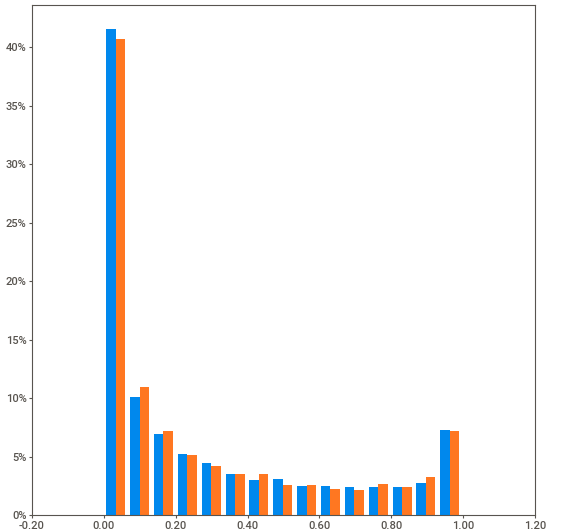
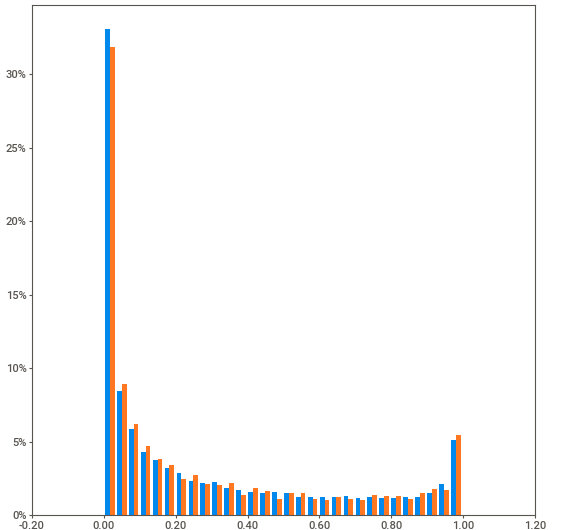
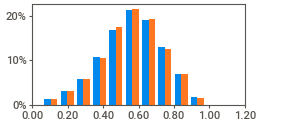
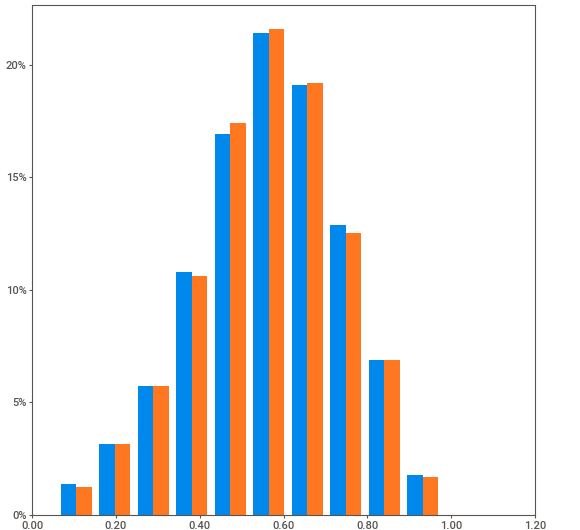
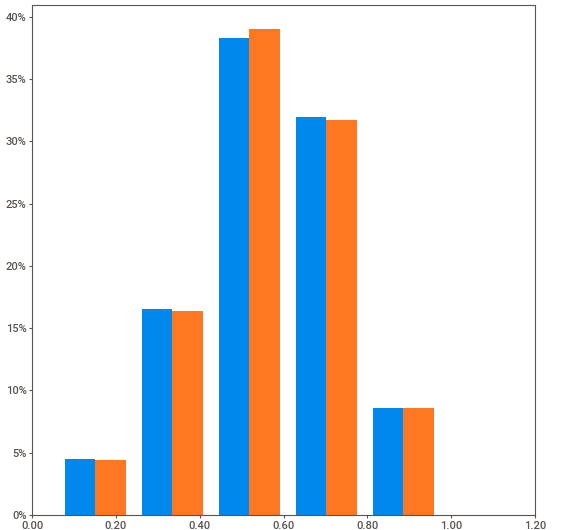
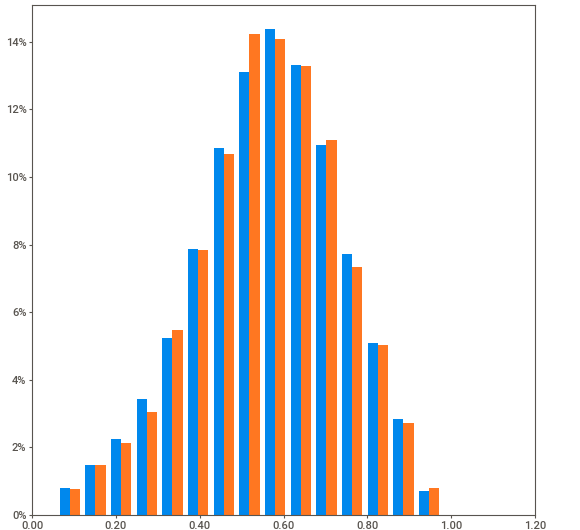
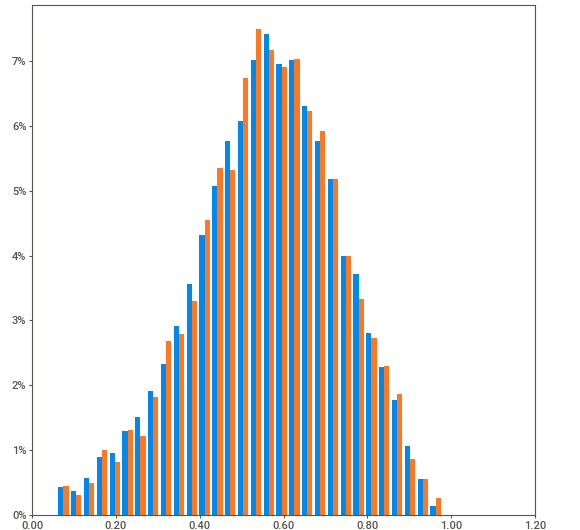
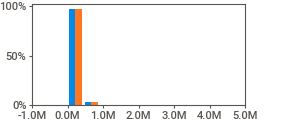
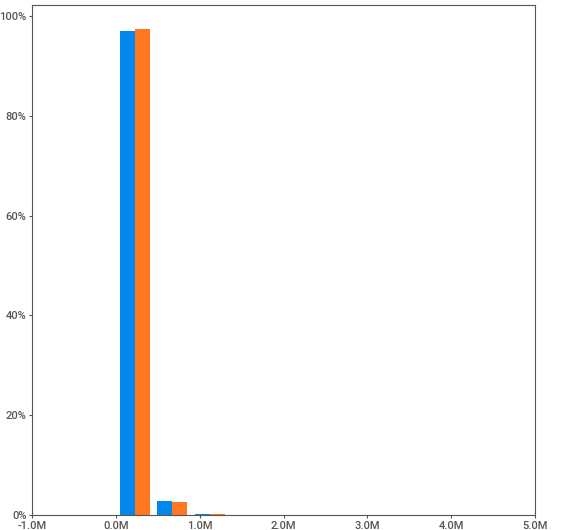
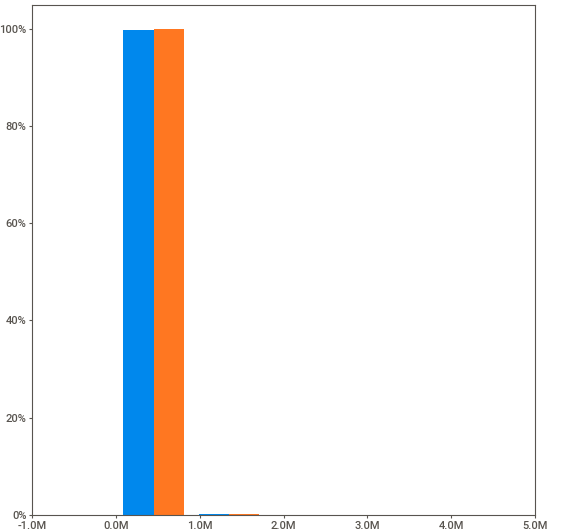
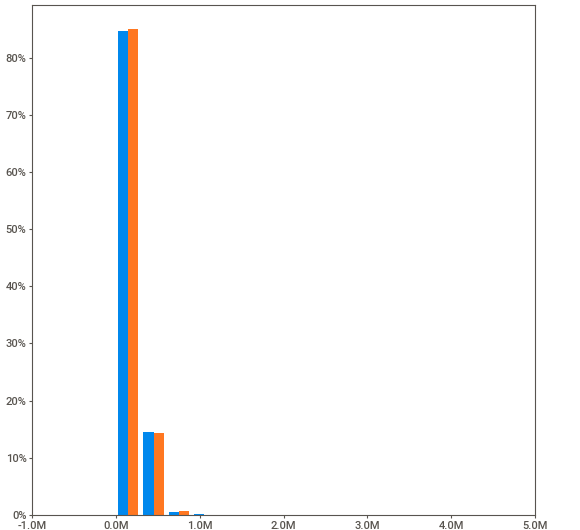
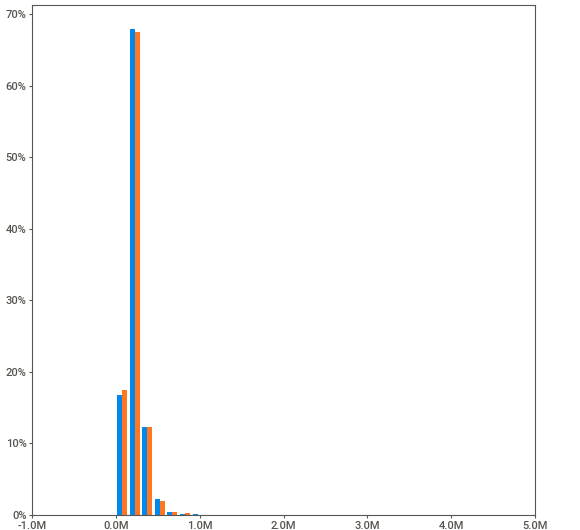
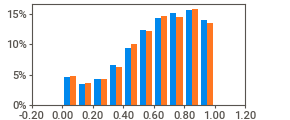
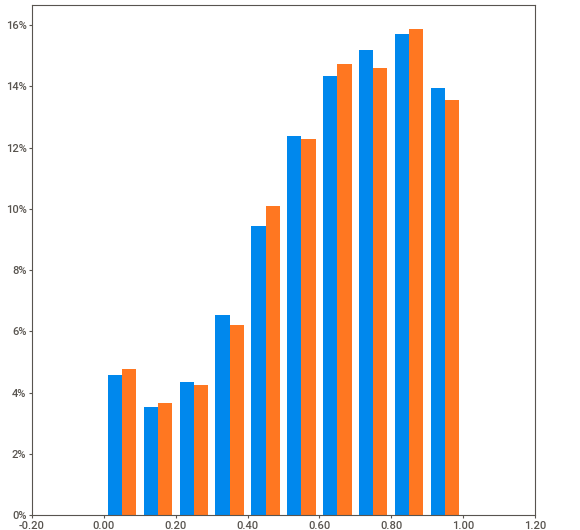
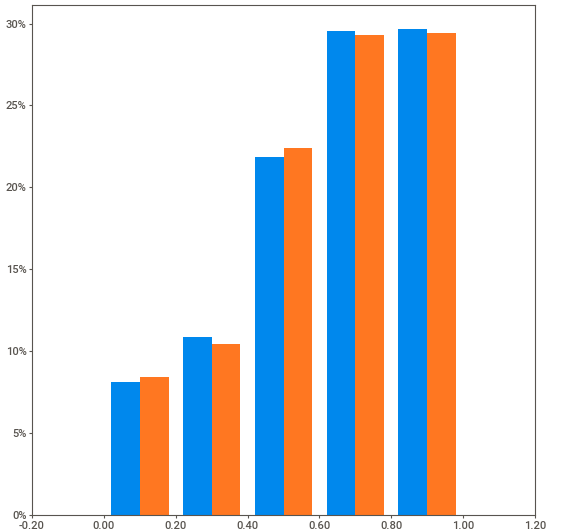
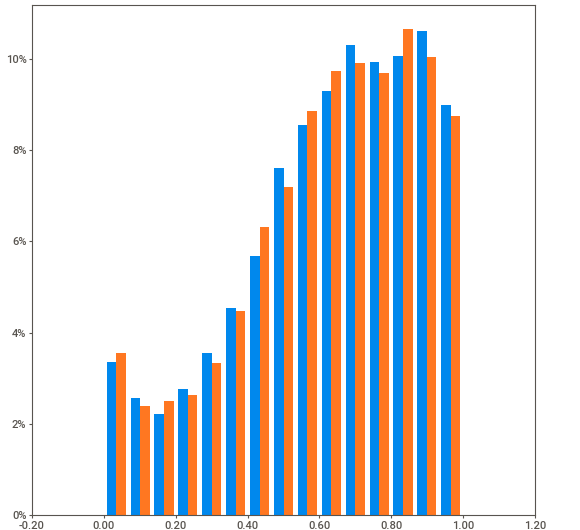
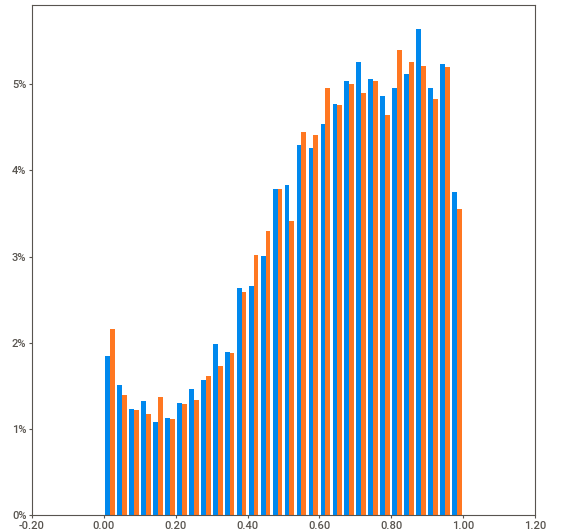
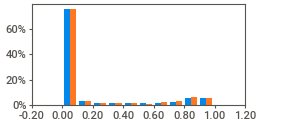
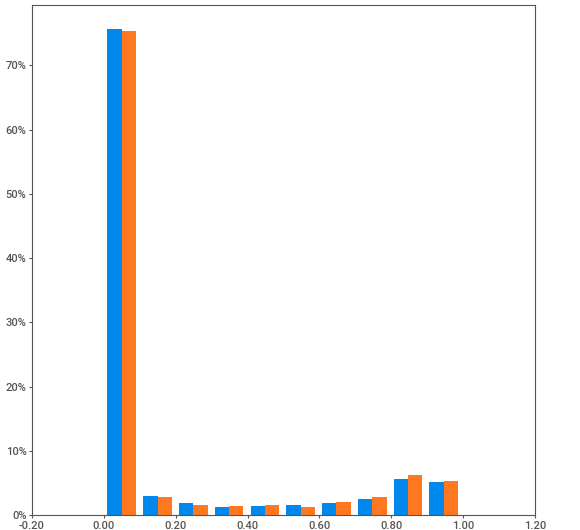
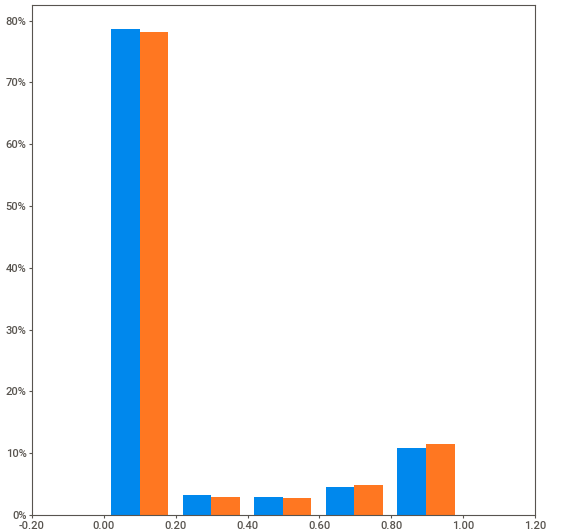
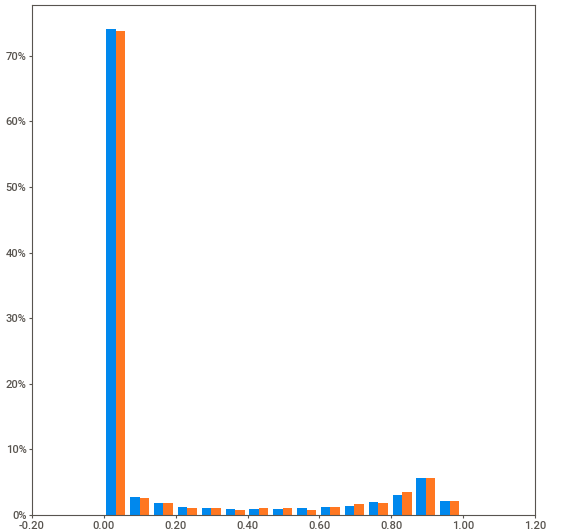
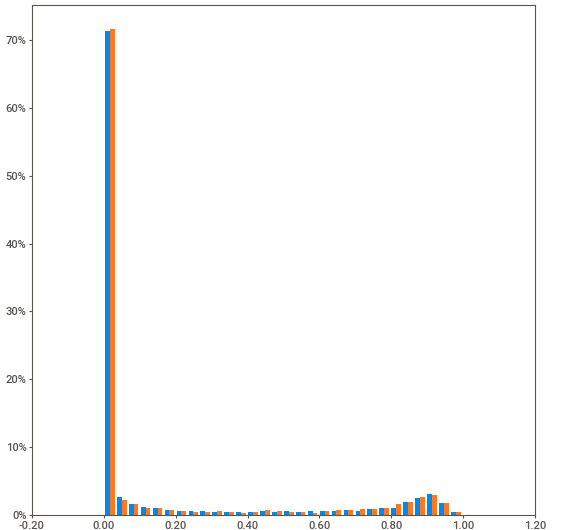
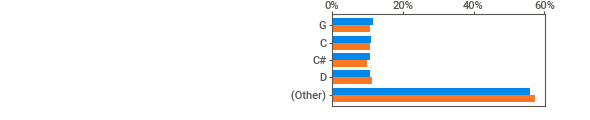
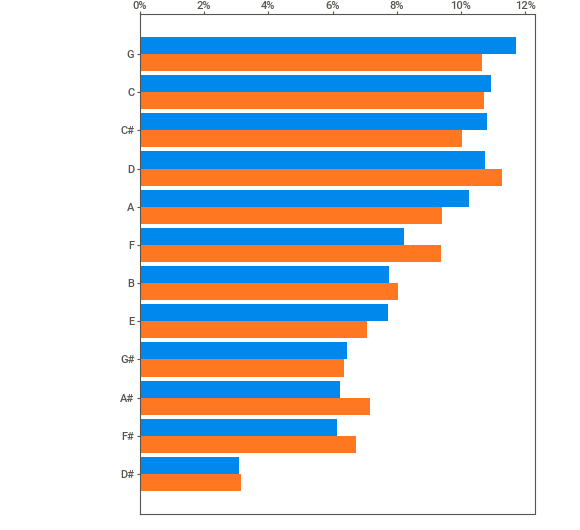
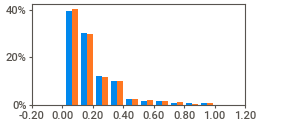
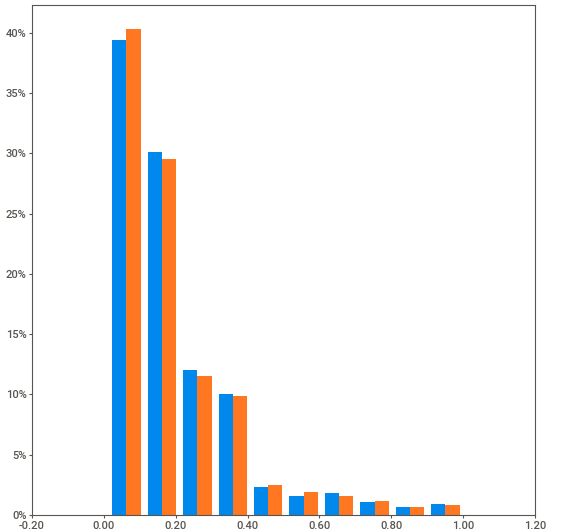
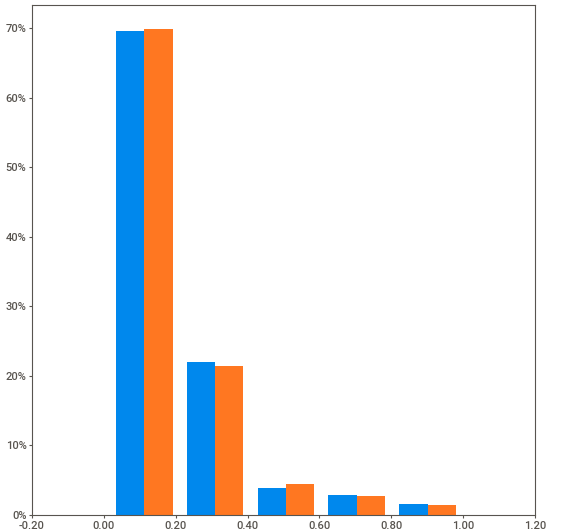
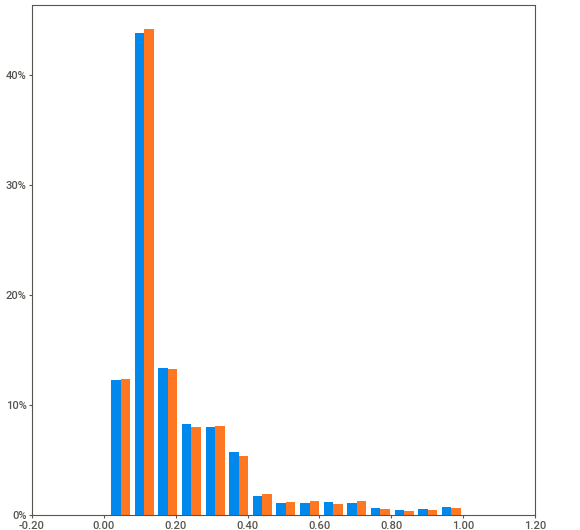
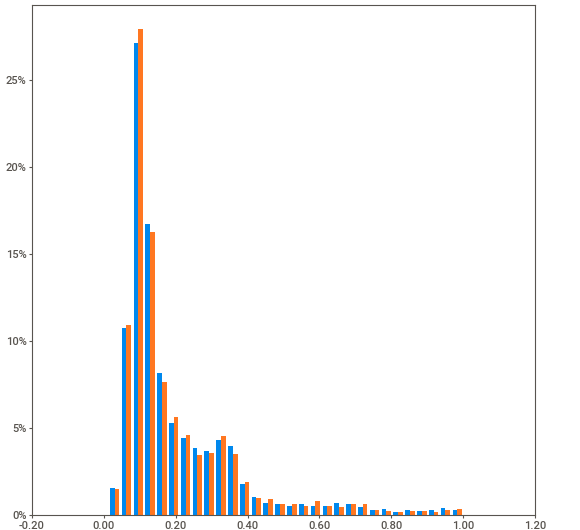
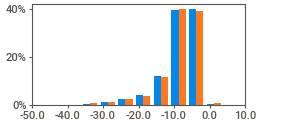
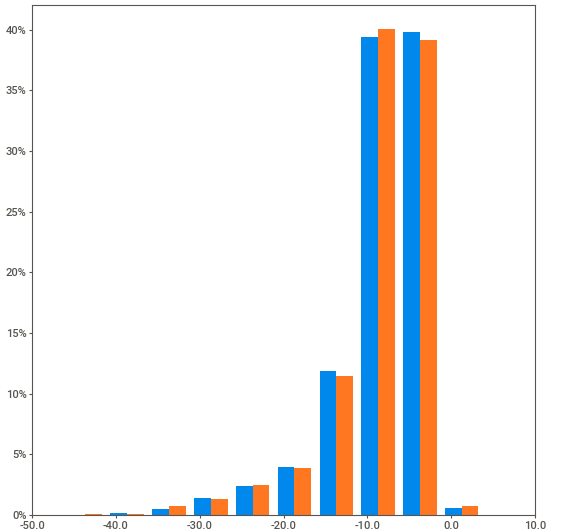
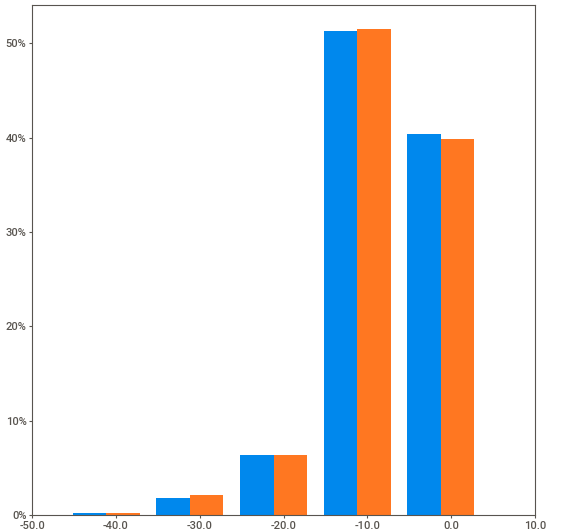
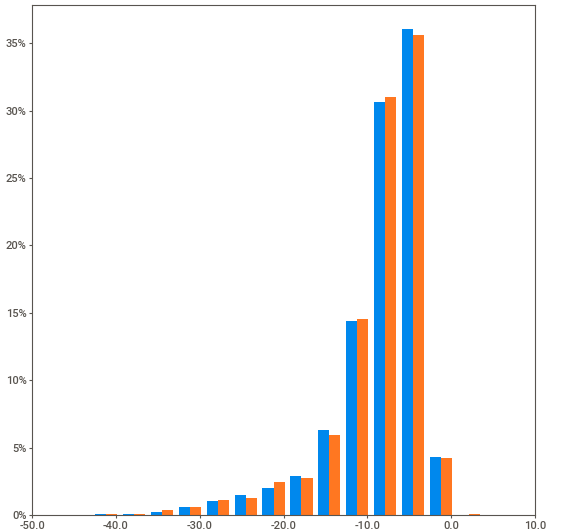
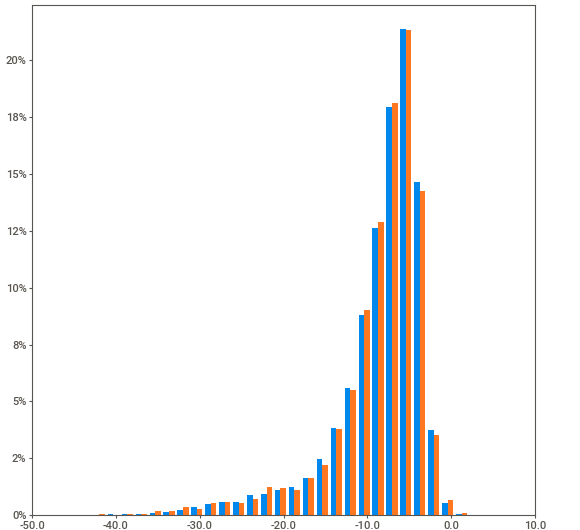
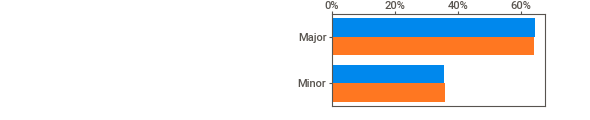
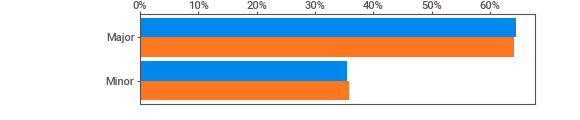
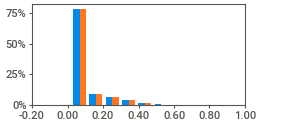
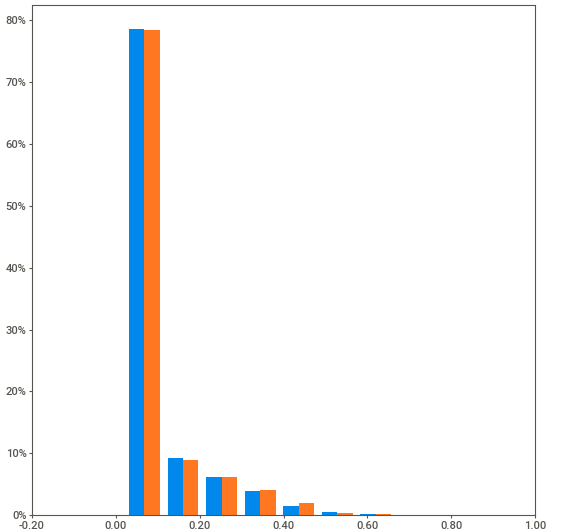
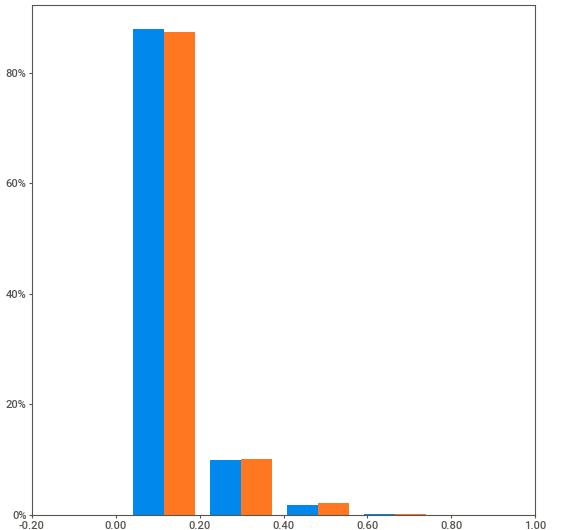
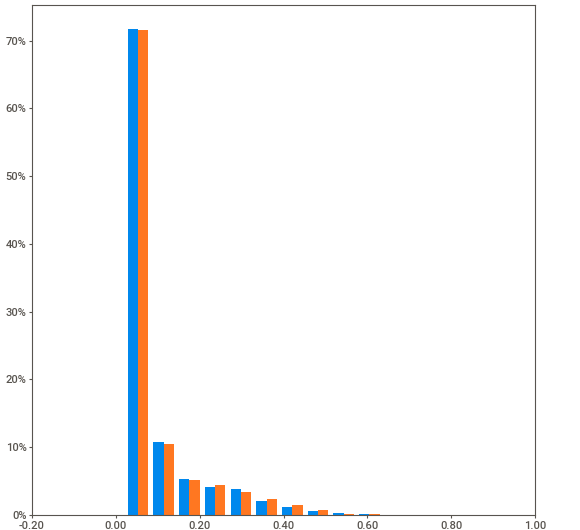
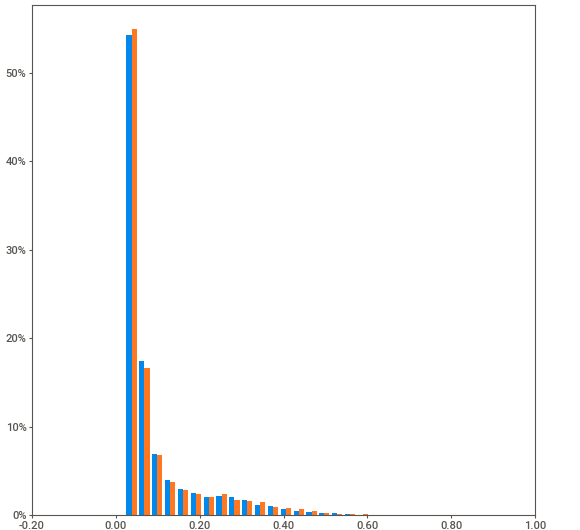
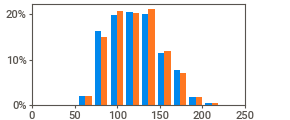
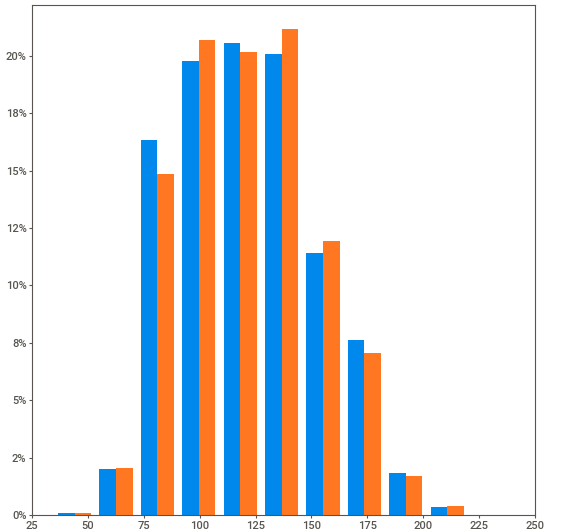
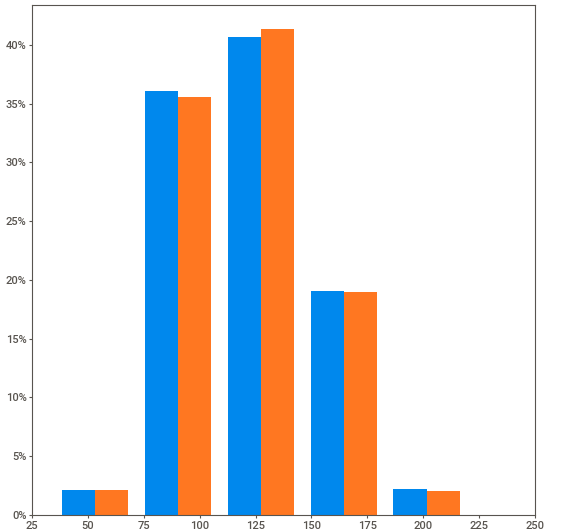
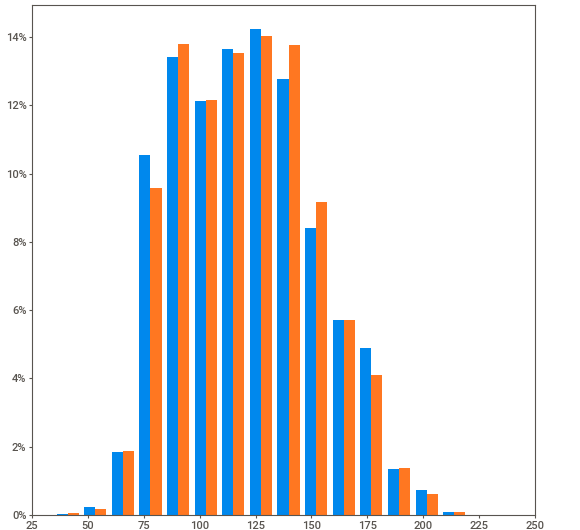
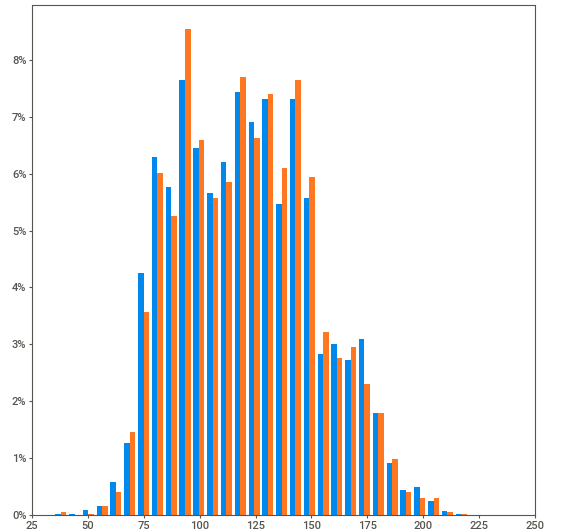
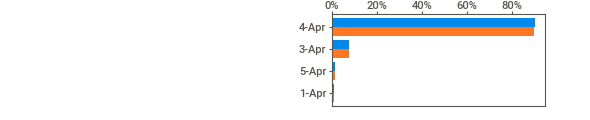
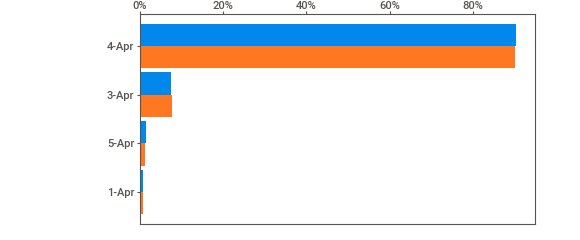
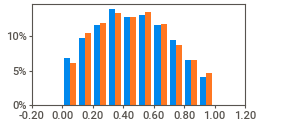
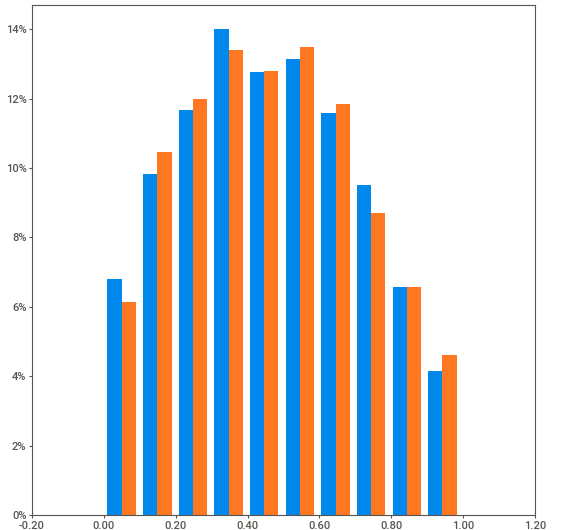
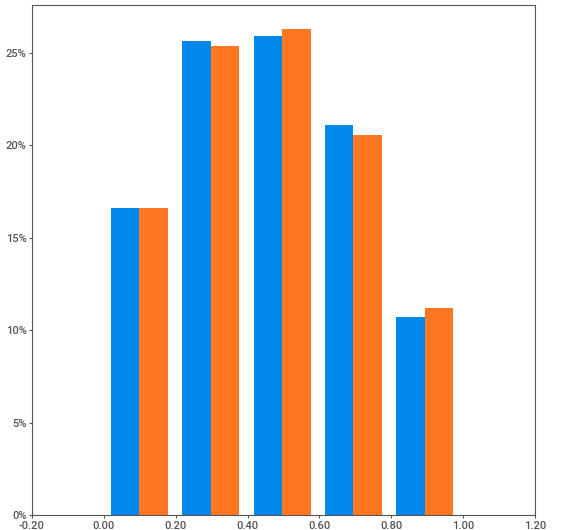
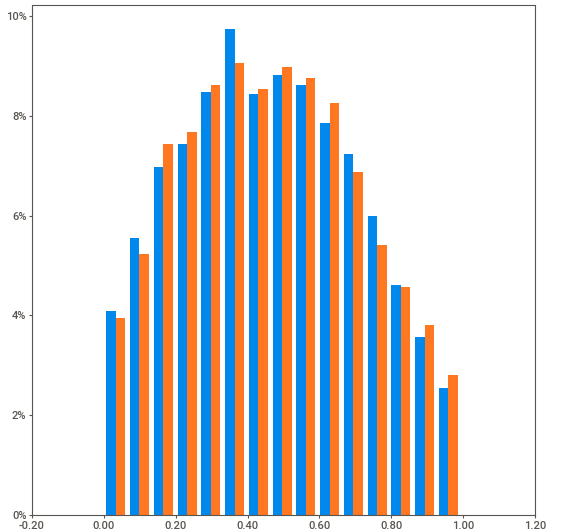
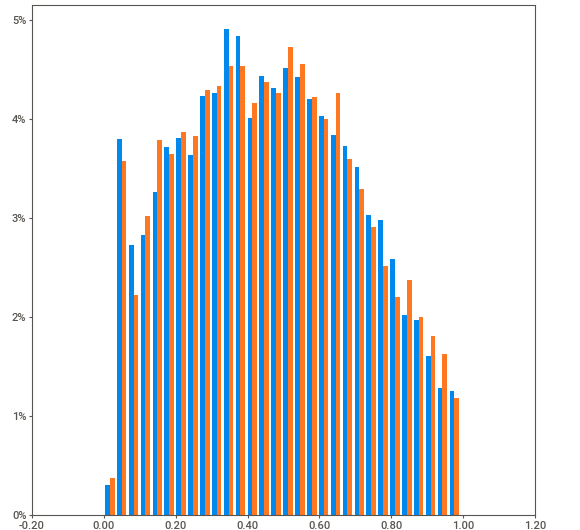
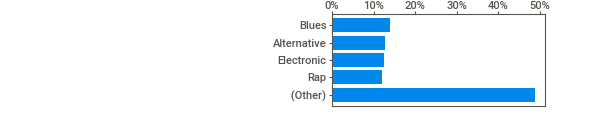
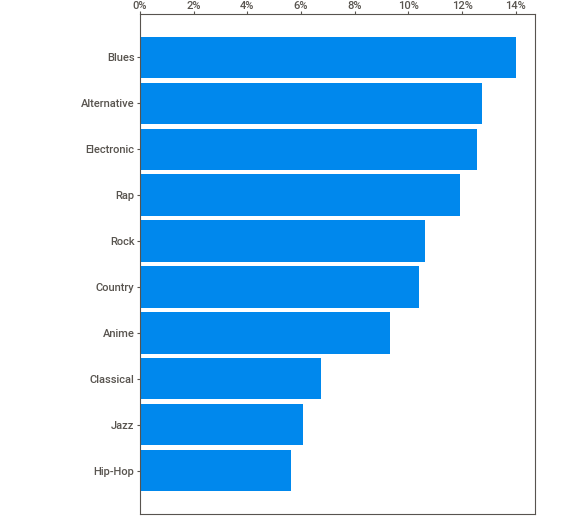
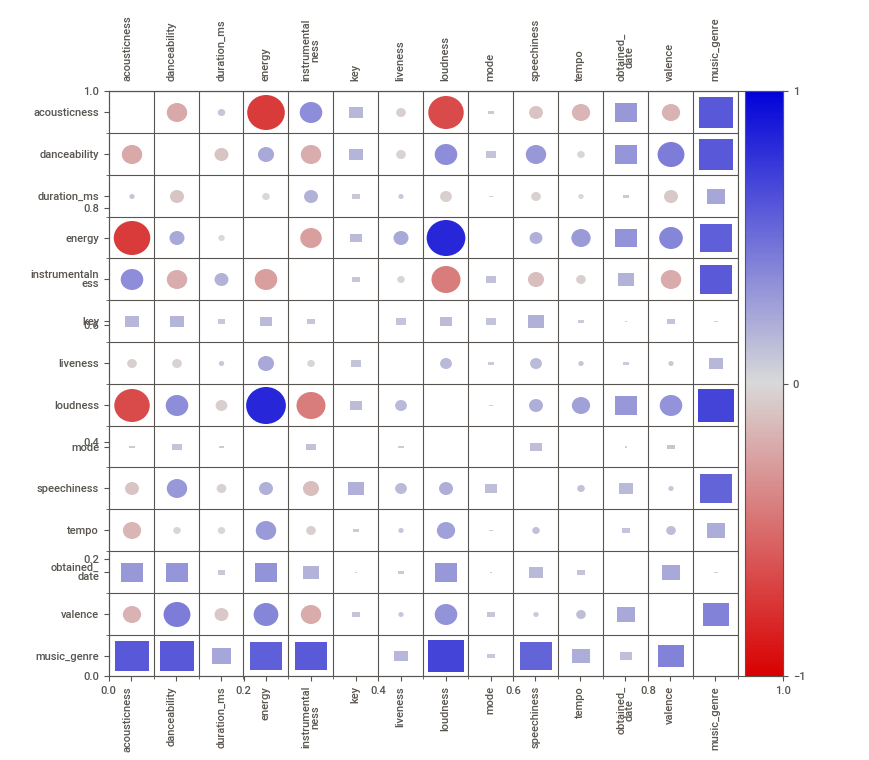
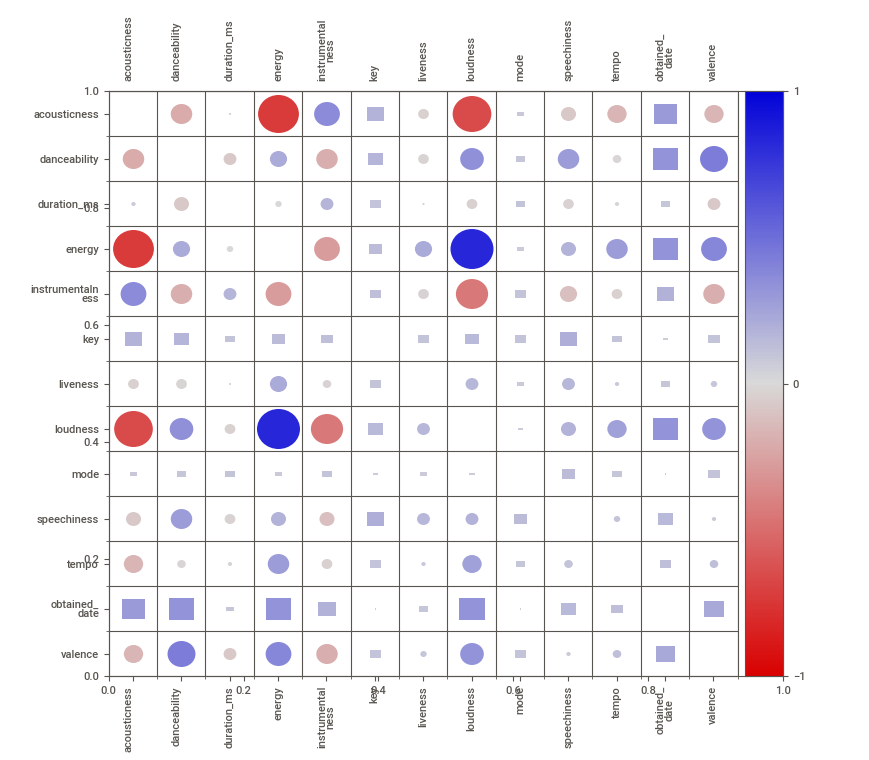

In [9]:
# Рассмотрю полученные данные. Сравнение тренировочной и тестовой выборок. 
comparison_report = sv.compare([df_train,'Train'], [df_test,'Test'])
comparison_report.show_notebook(layout='vertical', w=950, h=500, scale=0.8)
# comparison_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)


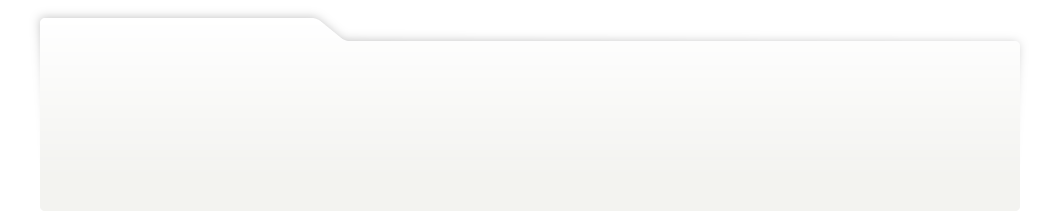
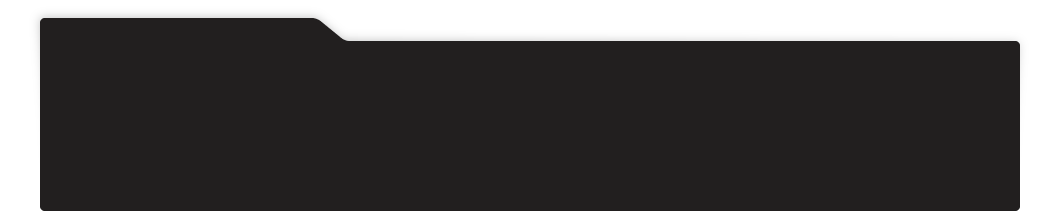
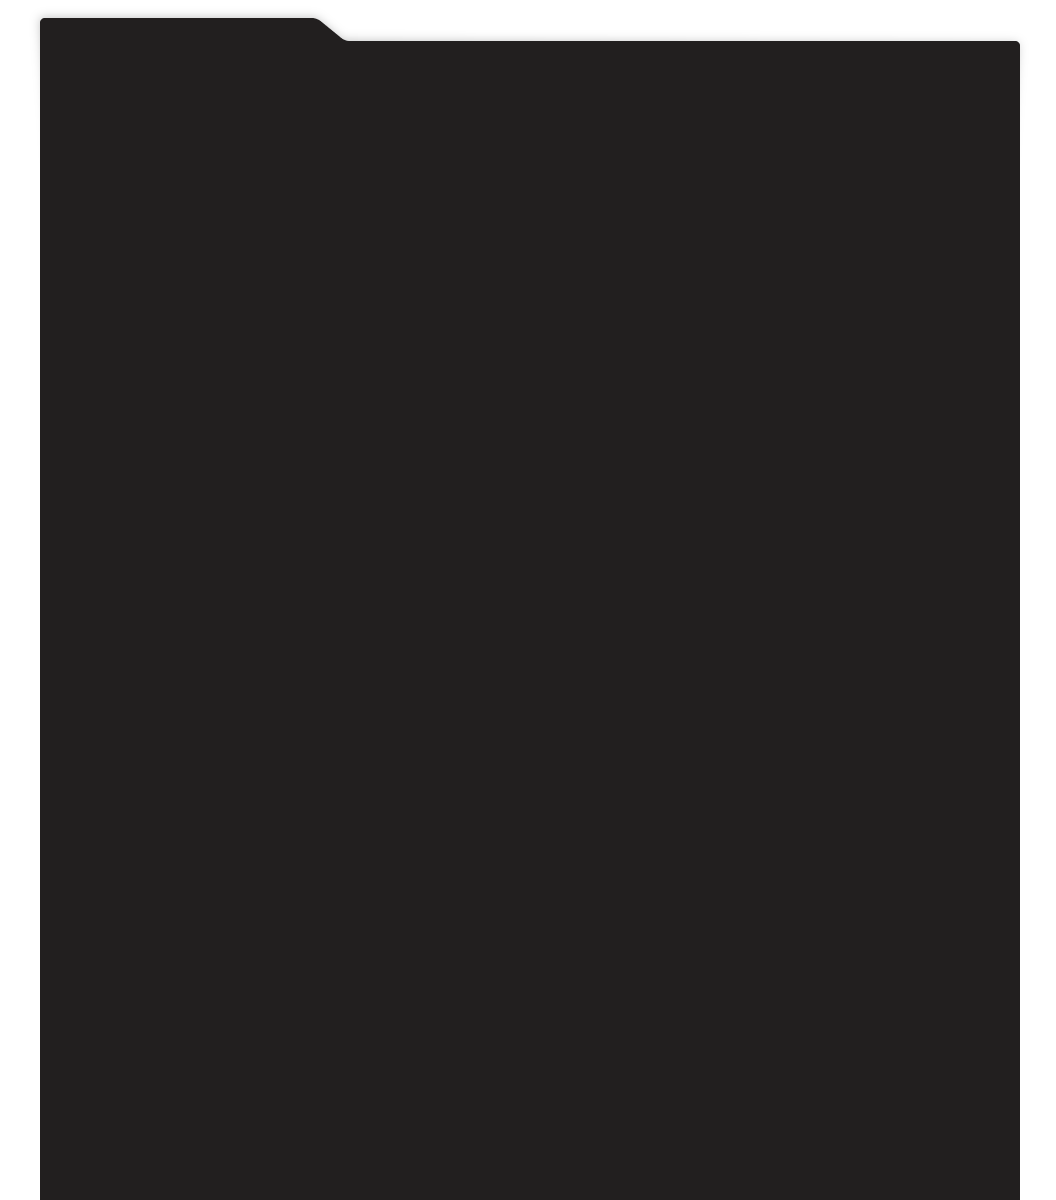
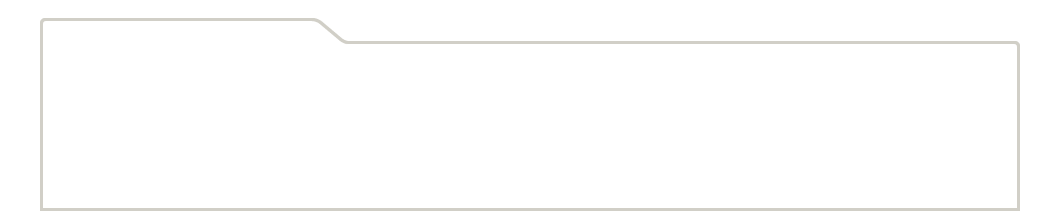
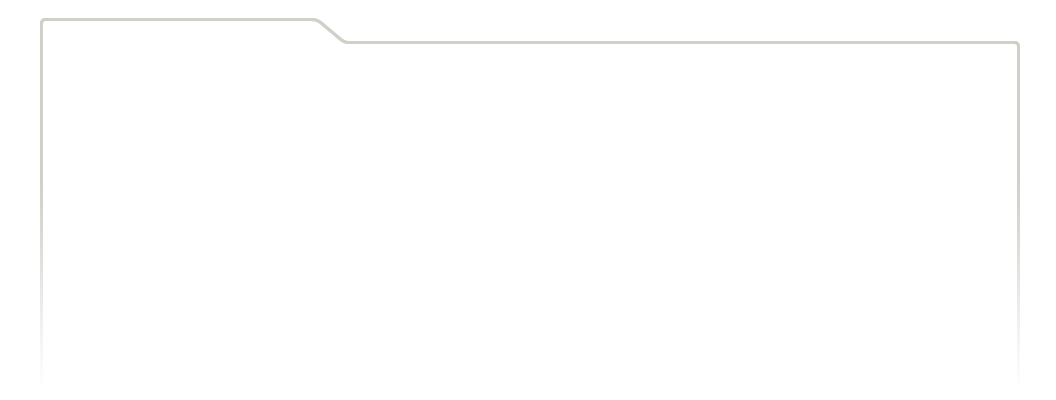
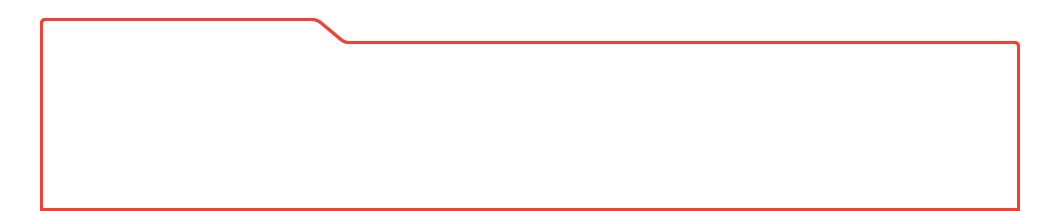
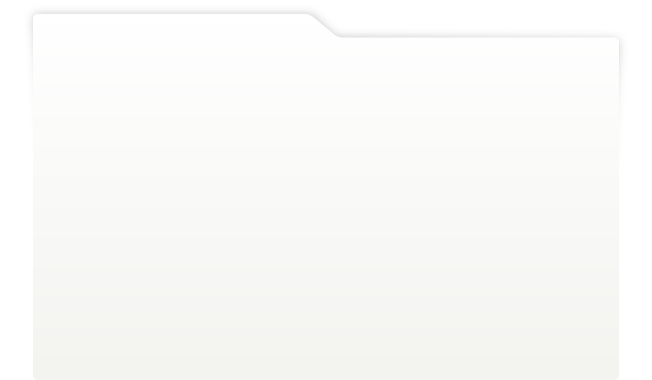
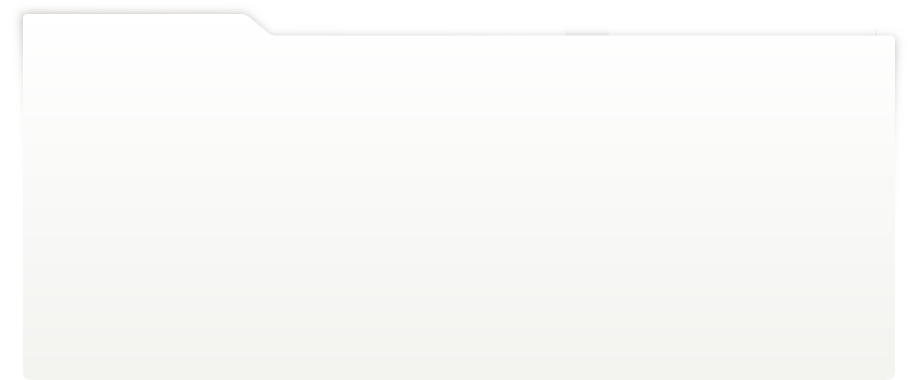
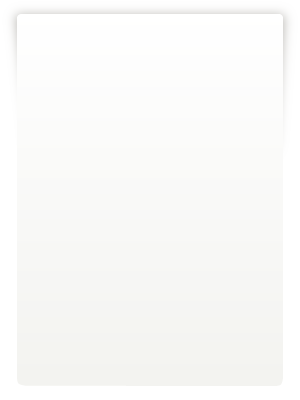
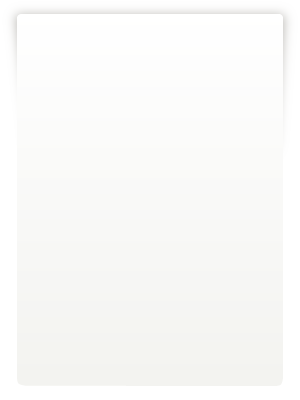
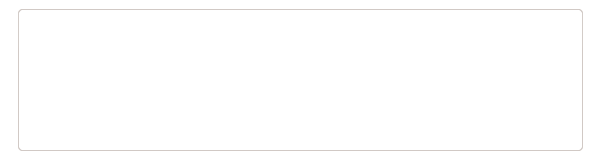
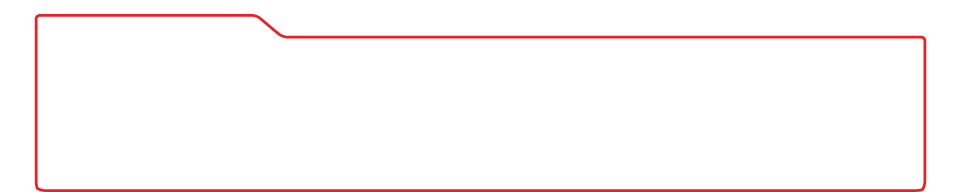
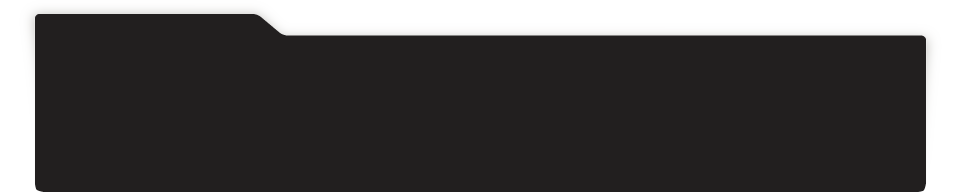
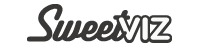
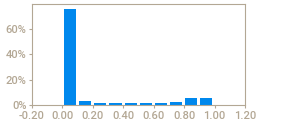
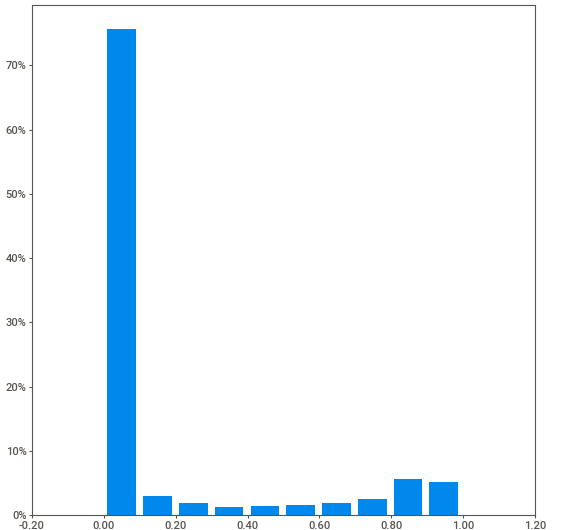
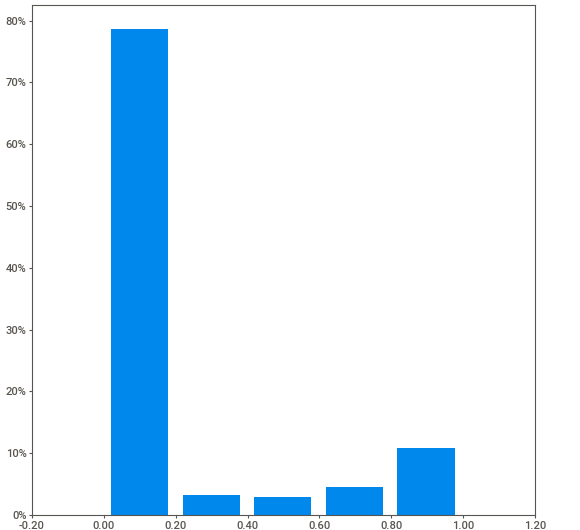
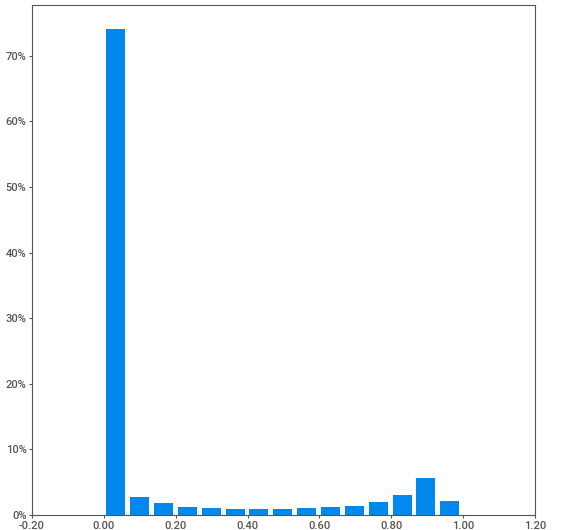
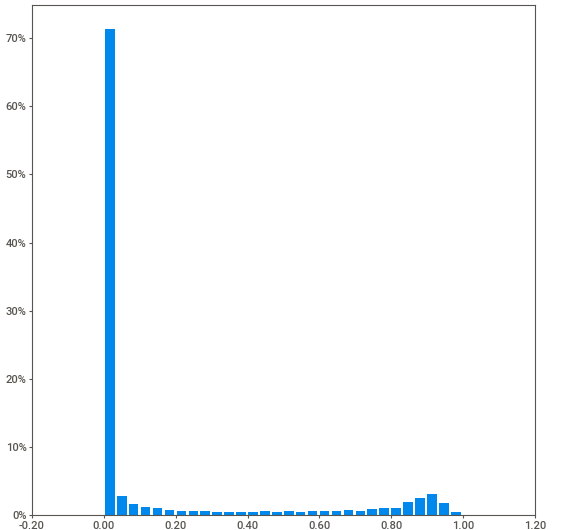
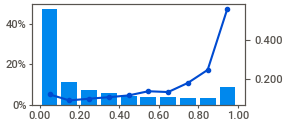
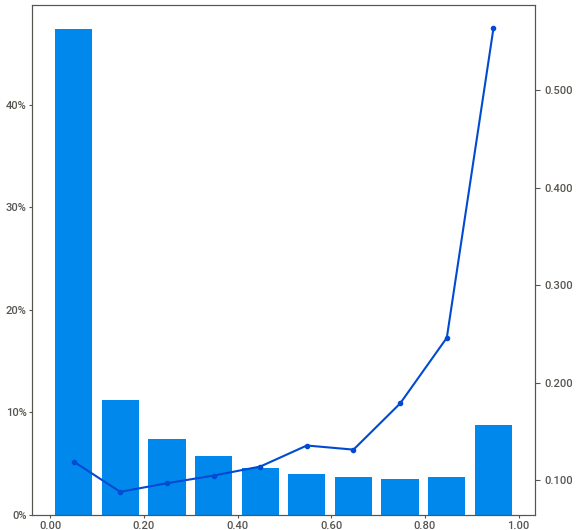
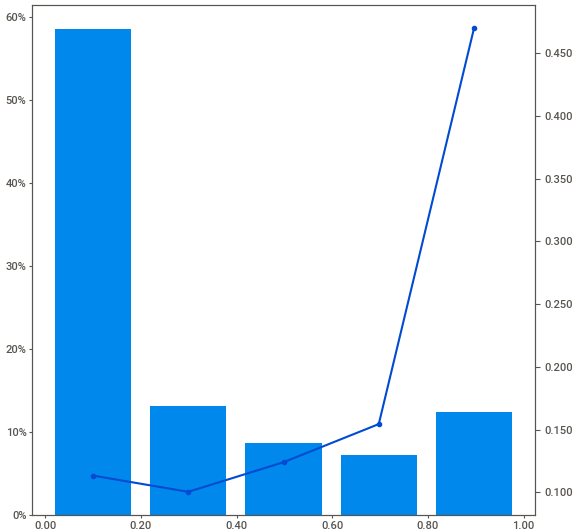
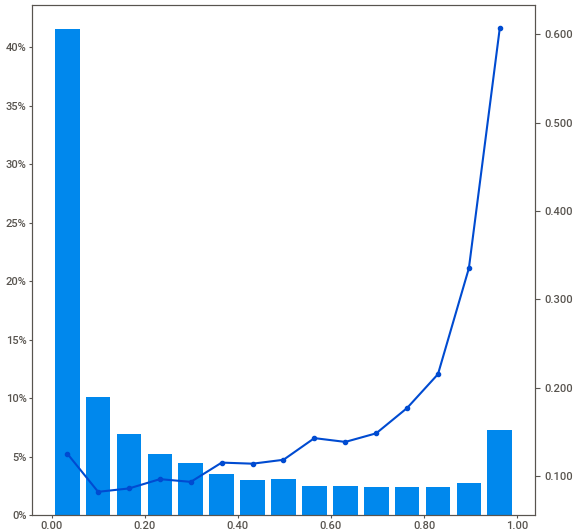
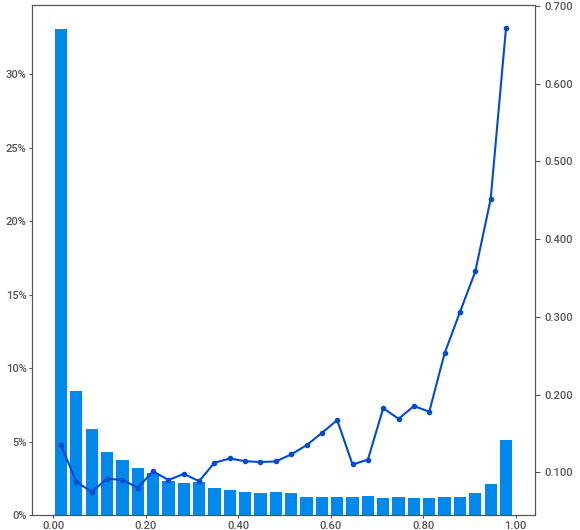
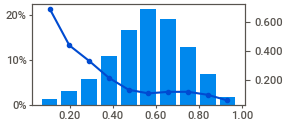
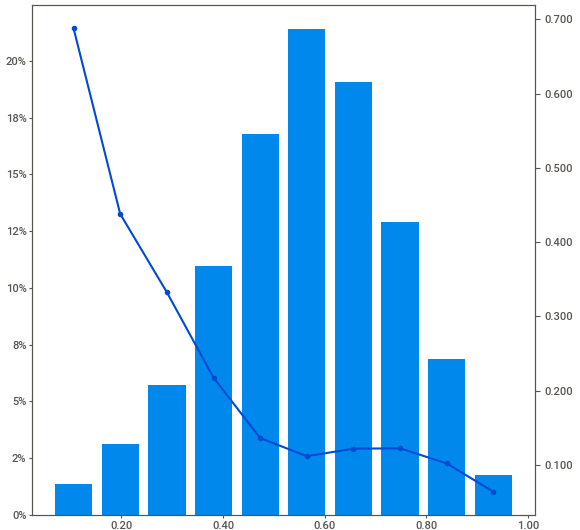
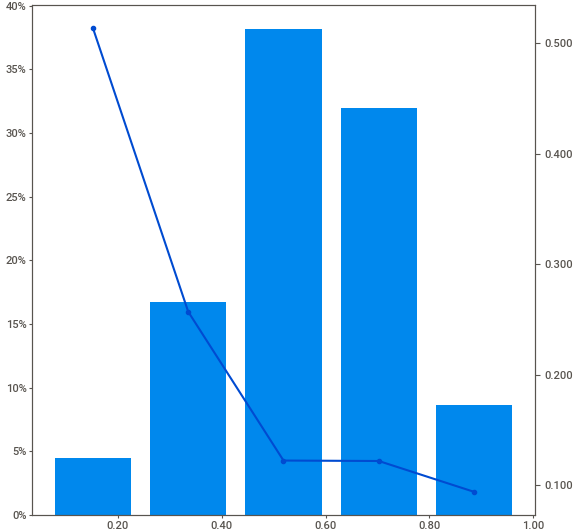
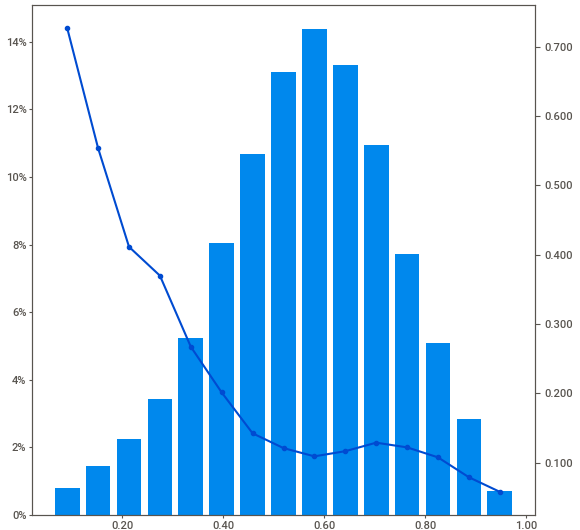
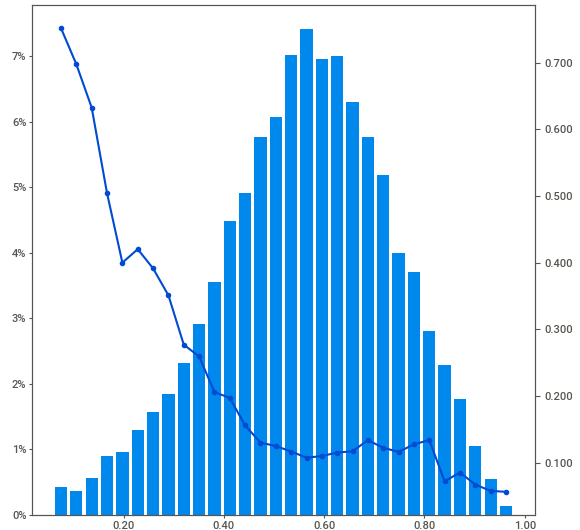
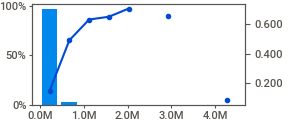
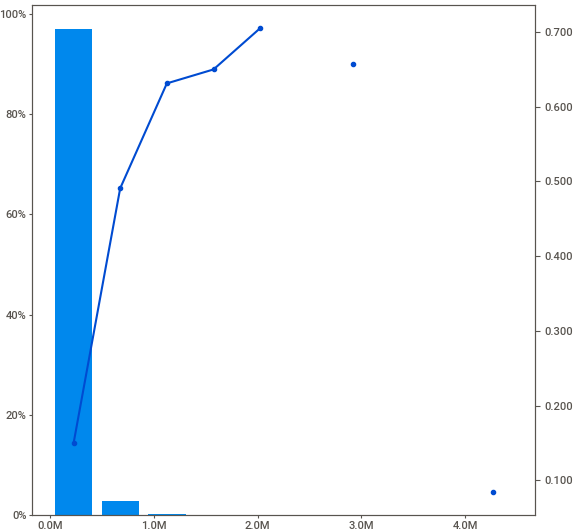
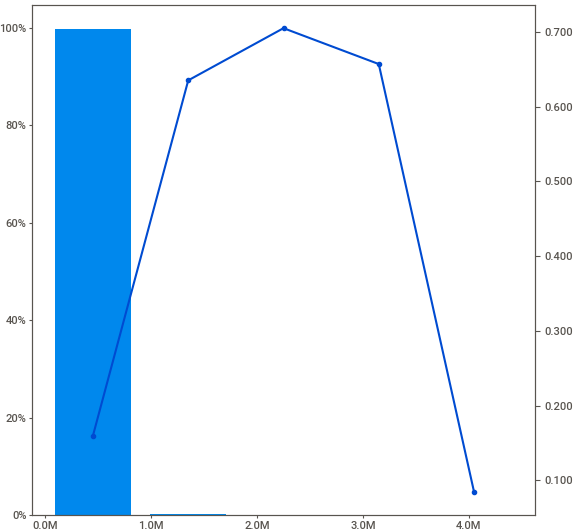
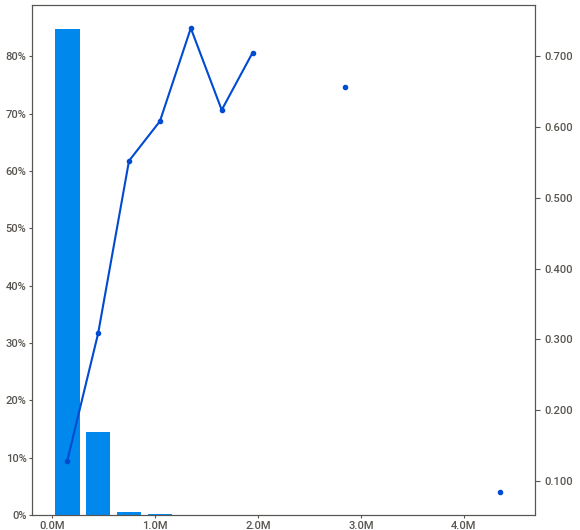
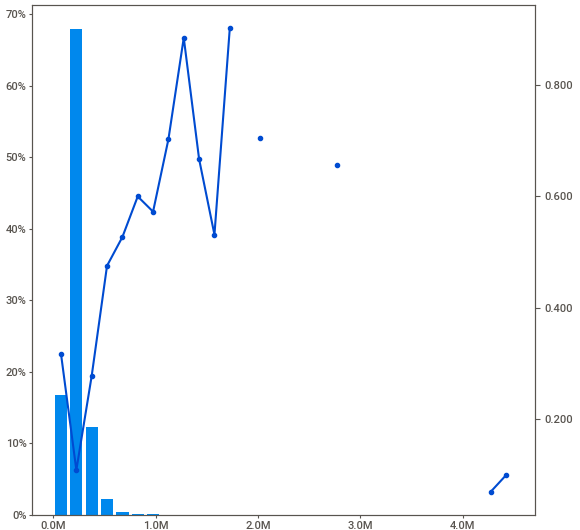
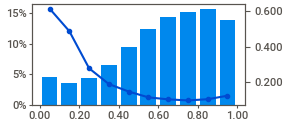
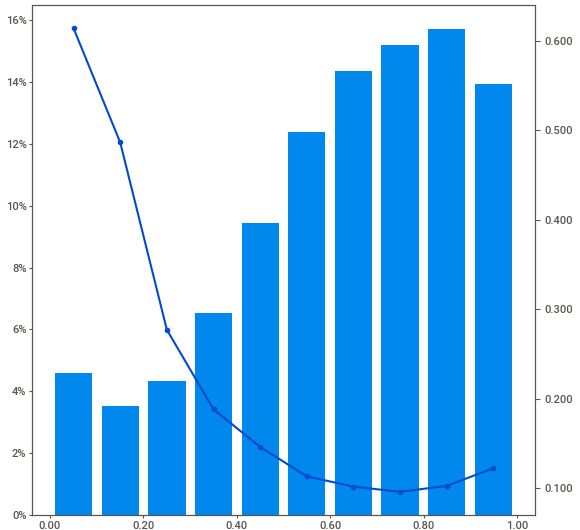
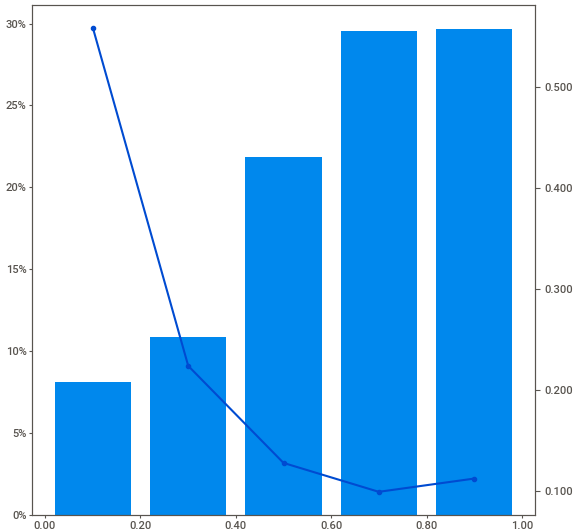
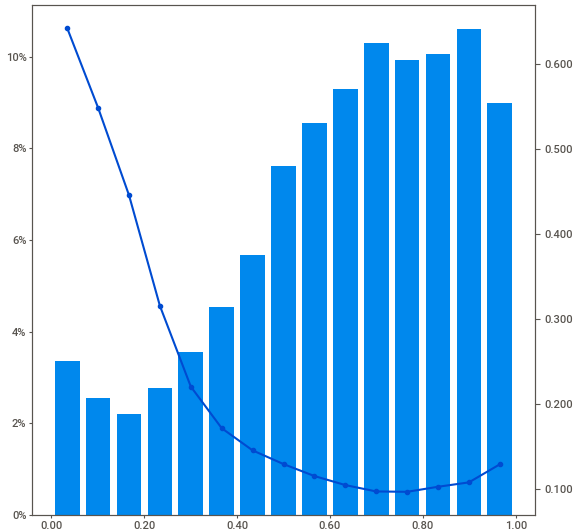
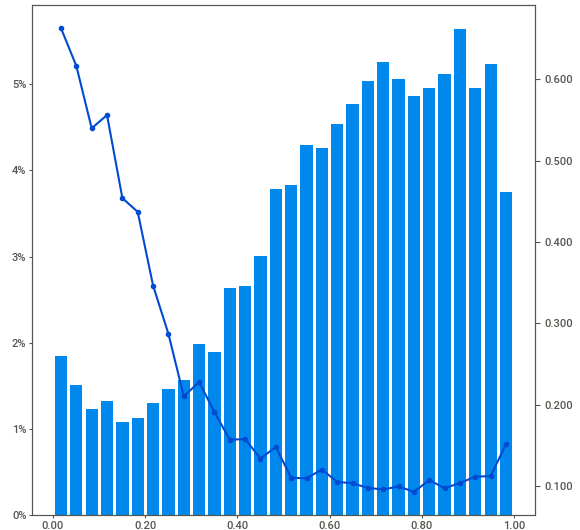
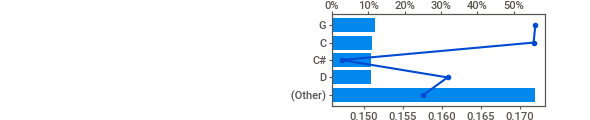
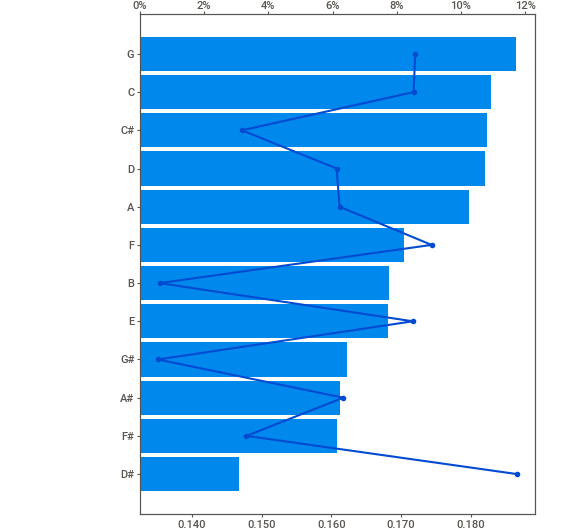
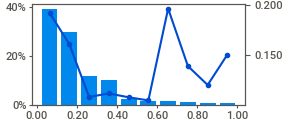
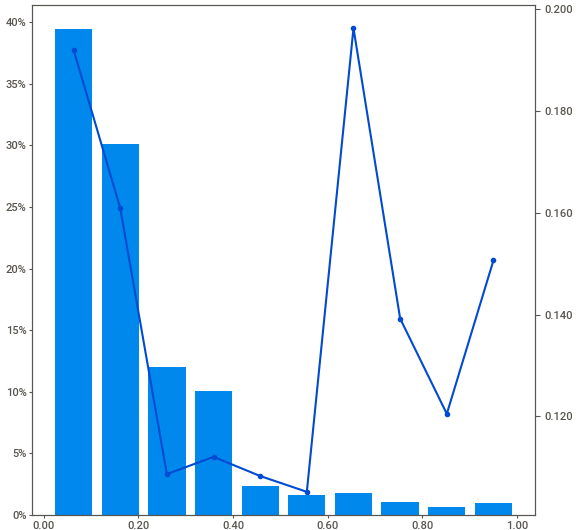
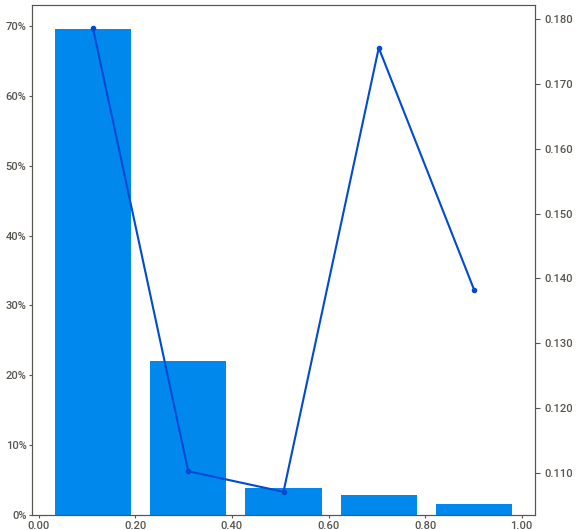
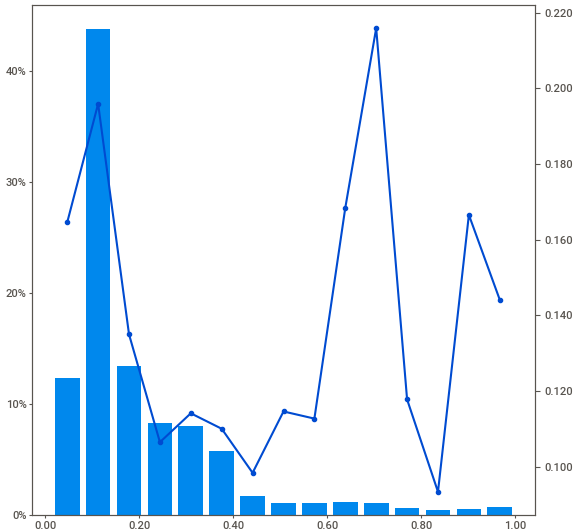
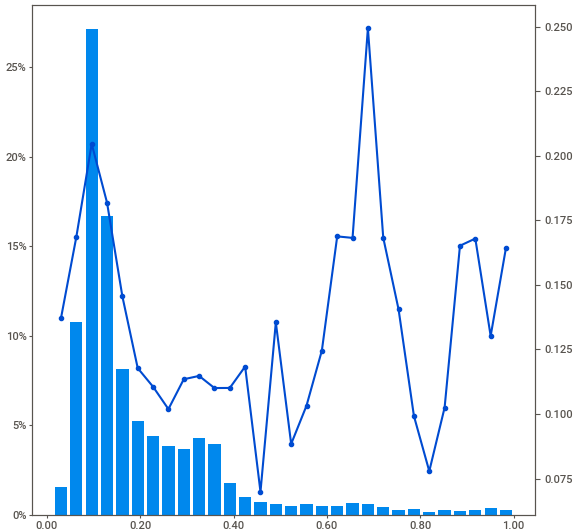
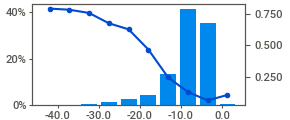
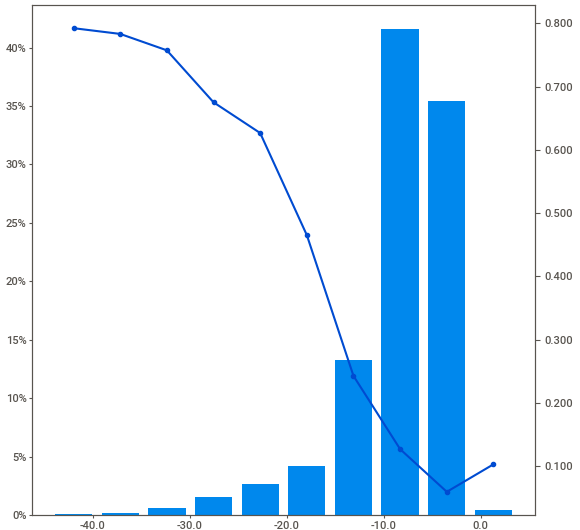
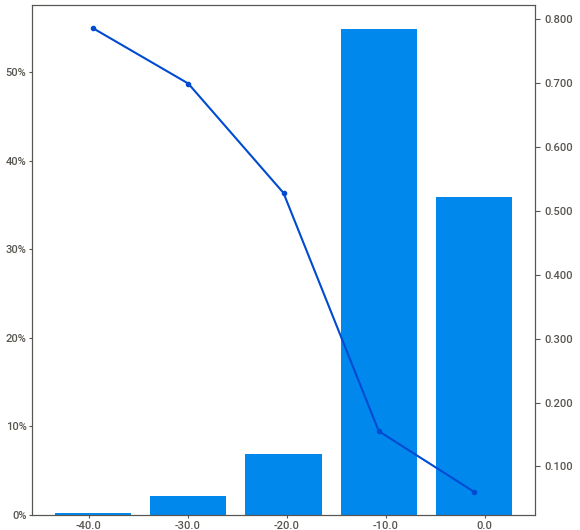
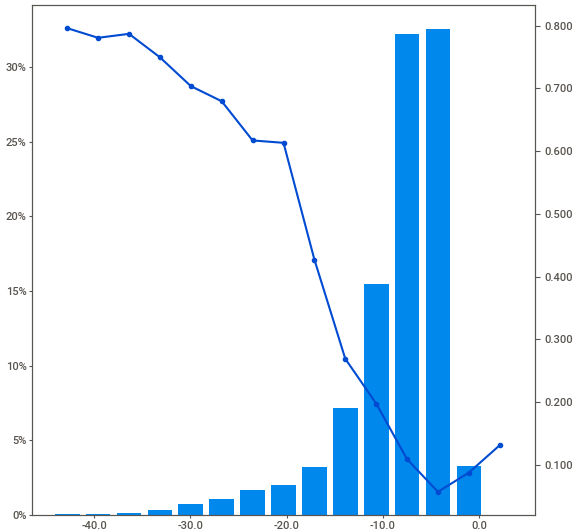
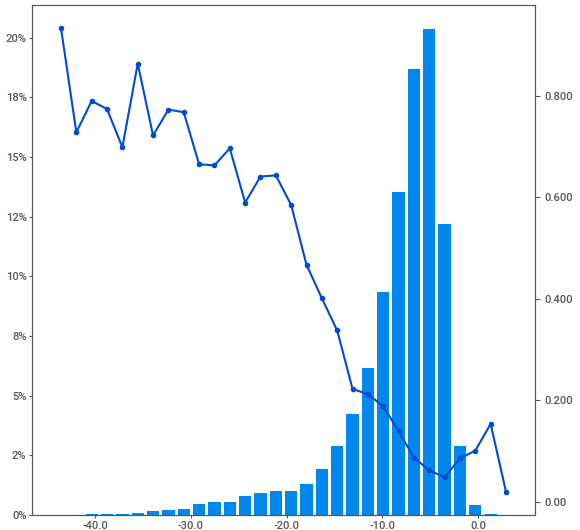
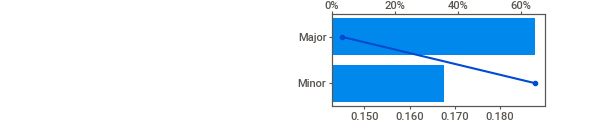
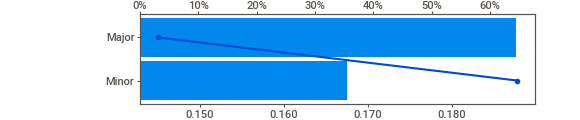
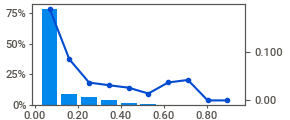
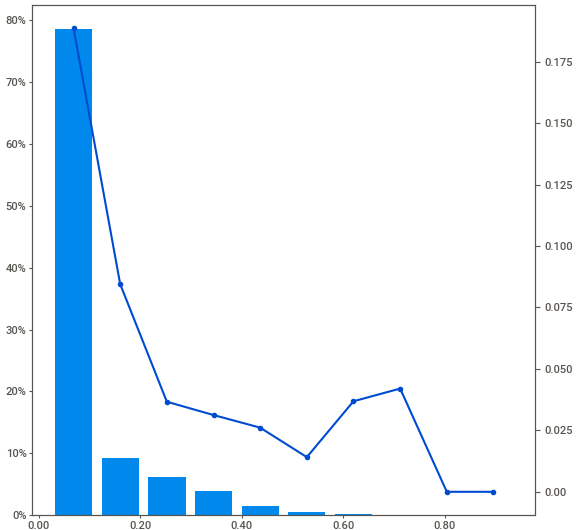
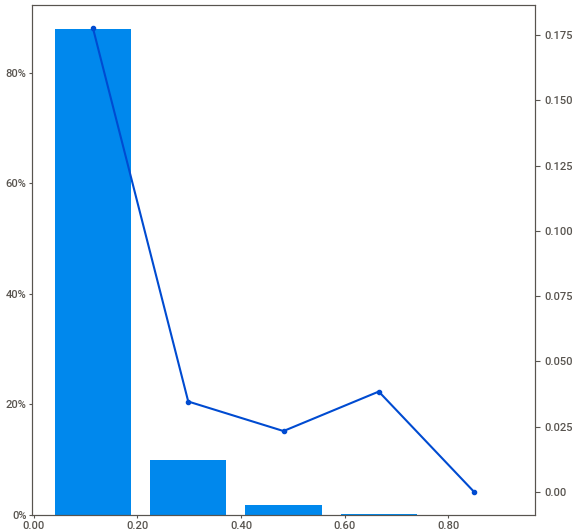
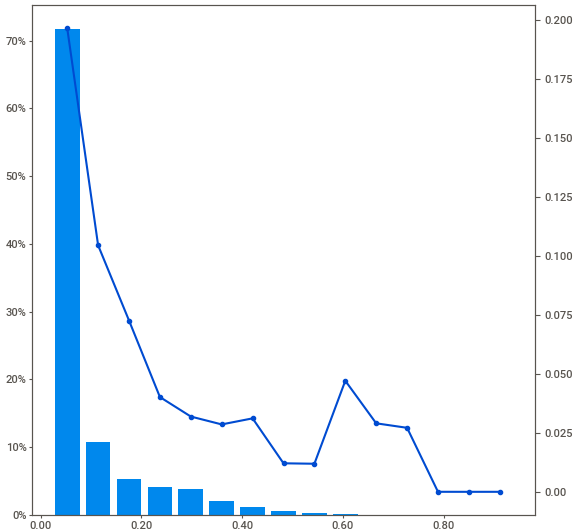
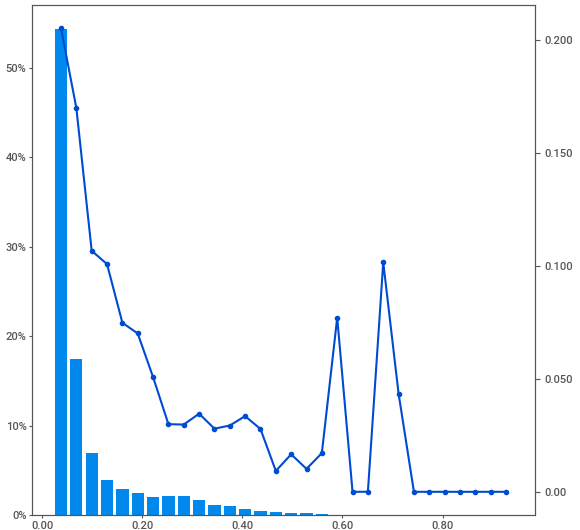
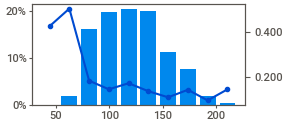
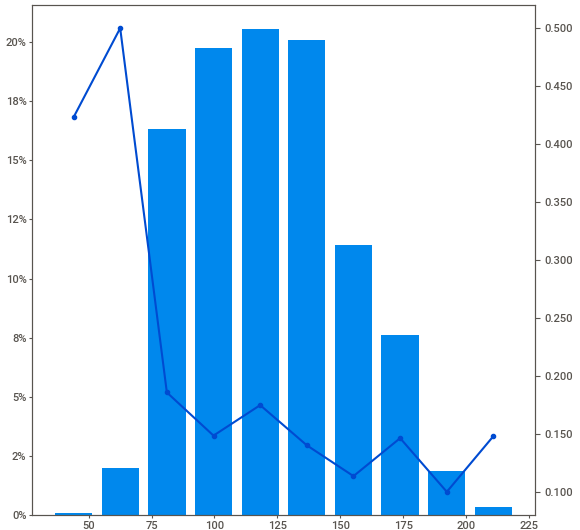
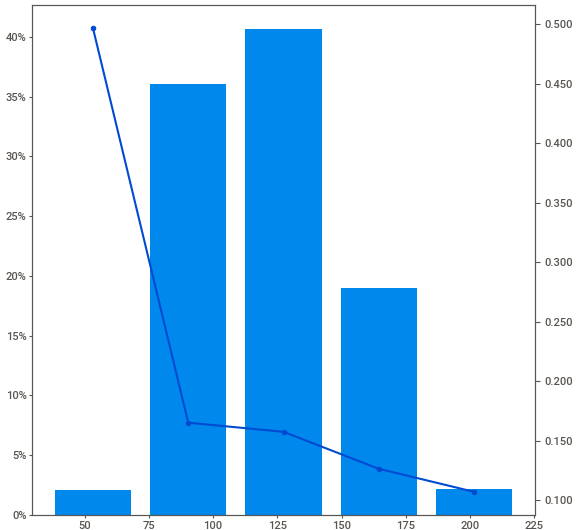
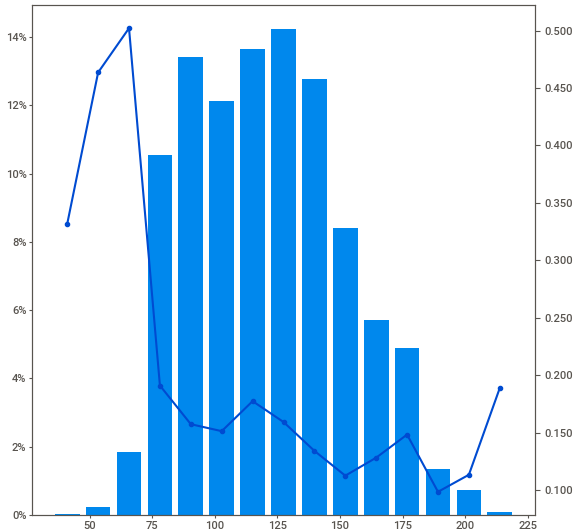
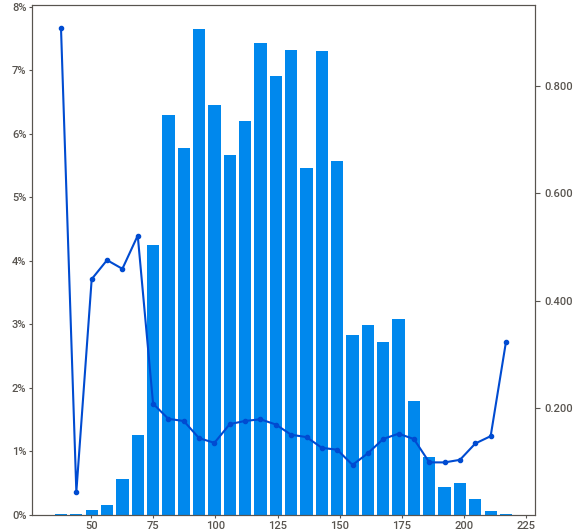
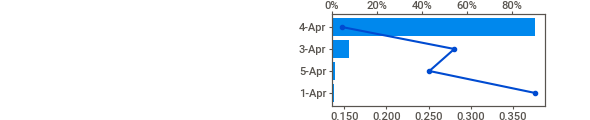
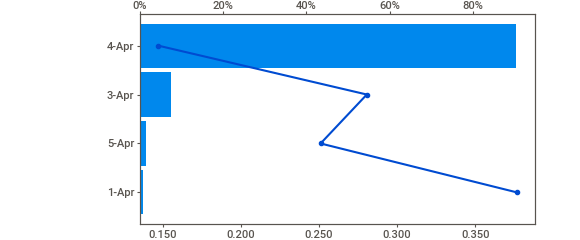
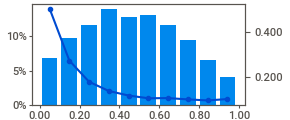
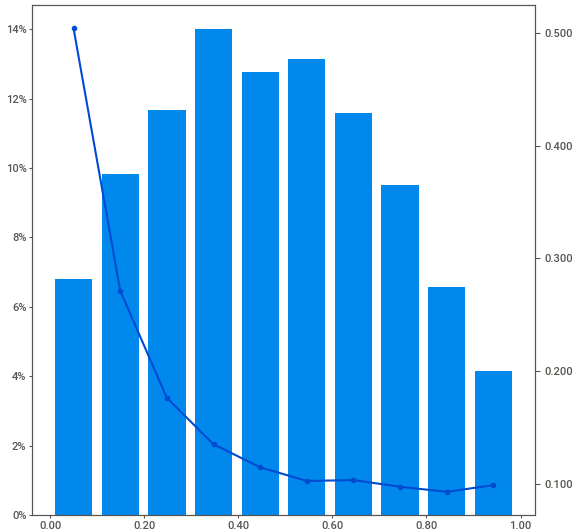
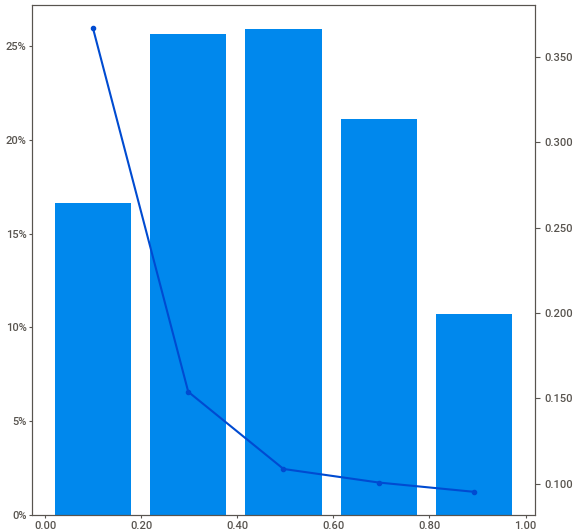
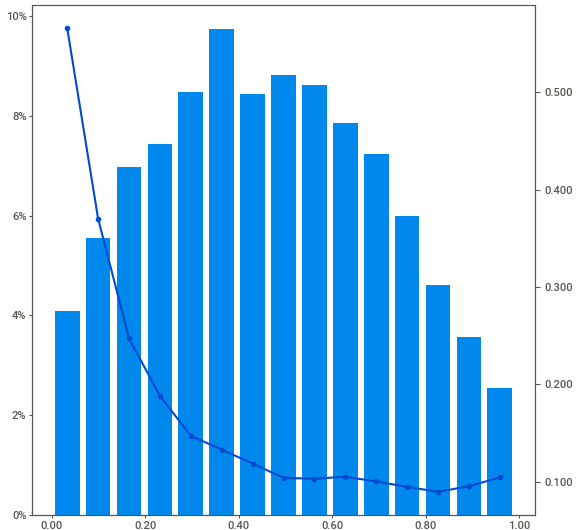
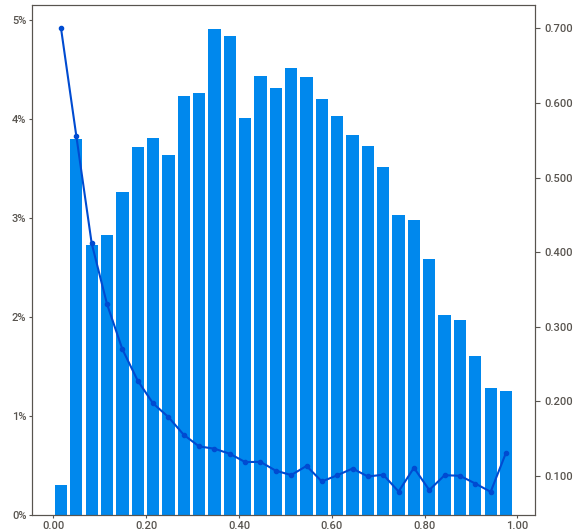
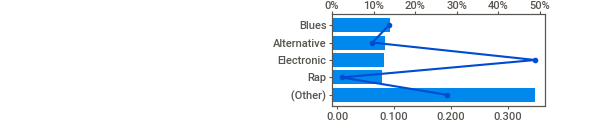
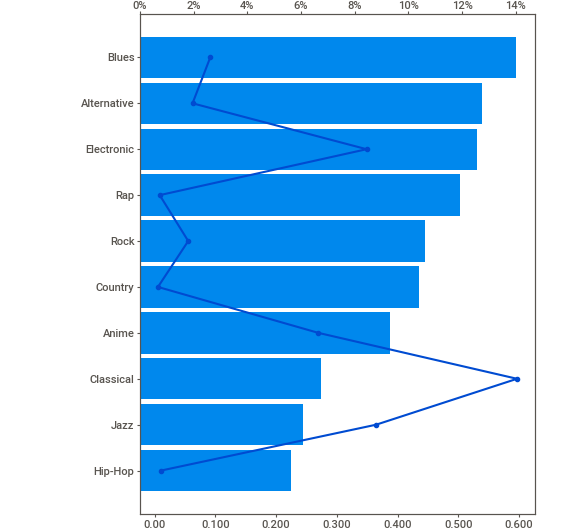
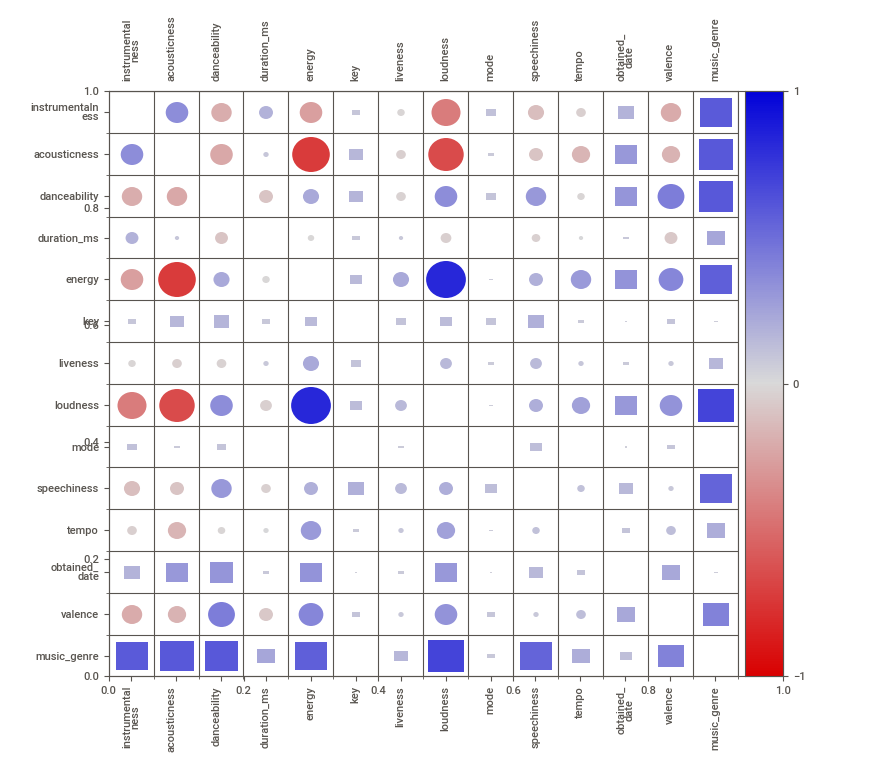
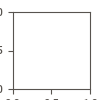

In [10]:
# Анализ поведения колонки 'instrumentalness'. 
analyze_report = sv.analyze([df_train, 'key'], 'instrumentalness', )
analyze_report.show_notebook()
# analyze_report.show_html()

В данных имеются пропуски в небольшом количестве. Также есть скрытые дубликаты, которые я удалю ниже. 

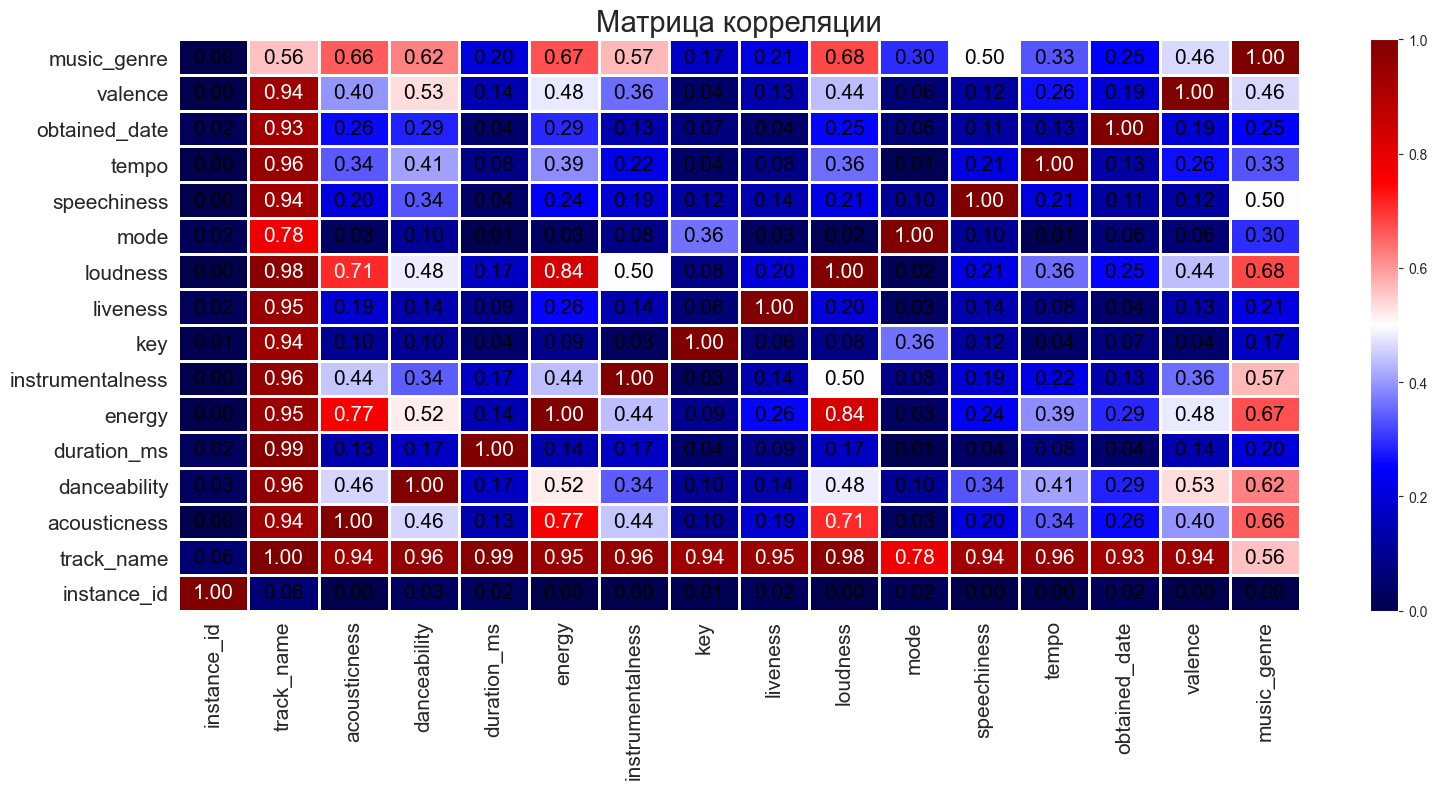

In [13]:
# Посмотрю на матрицу корреляции полученных признаков. 
ph_view = df_train.phik_matrix()

plot_correlation_matrix(ph_view.values,
                        x_labels=ph_view.columns,
                        y_labels=ph_view.index,
                        vmin=0, vmax=1, color_map='seismic',
                        title='Матрица корреляции',
                        fontsize_factor=1.5,
                        identity_layout=False,
                        figsize=(16, 8))
plt.tight_layout()

Наблюдается высокое влияние колонок acousticness, energy, loudness, danceability и instrumentalness на колонку с целевым показателем. 
Надо будет попробовать:
1. их удалить
2. добавить новую колонку с их средним арифметическим либо суммой и посмотреть на изменение показателя F1.  

После ряда экспериментов не удалось добиться улучшения показателей моделей. Наилучший показатель оказался самым первым, без каких-либо действий с колонками, вызывающими мультиколлинеарность. 

[К оглавлению](#section_0)
<a id='section_2.1'></a>
#### Предобработка и добавление синтетических признаков. 

In [13]:
# Добавлю новый признак равный длине имени трека. 
df_train['len_track_name'] = df_train.track_name.transform(lambda x: len(x))
df_test['len_track_name'] = df_test.track_name.transform(lambda x: len(x))

df_train['count_track_name'] = df_train.track_name.transform(lambda x: len(x.split()))
df_test['count_track_name'] = df_test.track_name.transform(lambda x: len(x.split()))

df_train['word'] = df_train.len_track_name / df_train.count_track_name
df_test['word'] = df_test.len_track_name / df_test.count_track_name

df_train.drop('count_track_name', axis=1, inplace=True)
df_test.drop('count_track_name', axis=1, inplace=True)

In [14]:
# Проверю дубликаты
df_train.duplicated(subset=[
    'track_name', 'acousticness', 'energy', 'danceability', 'instrumentalness',
    'duration_ms', 'valence', 'speechiness',
]).sum()

557

In [15]:
# Удалю эти дубликаты
df_train = (df_train.drop_duplicates(subset=[
    'track_name', 'acousticness', 'energy', 'danceability', 'instrumentalness',
    'duration_ms', 'valence', 'speechiness',
],
    keep='first'))

In [16]:
# контроль
df_train.duplicated(subset=[
    'track_name', 'acousticness', 'energy', 'danceability', 'instrumentalness',
    'duration_ms', 'valence', 'speechiness',
]).sum()

0

In [17]:
# Удалю колонки с именем трека и датой. 
df_train = df_train.drop(['track_name', 'obtained_date'], axis=1)
df_test = df_test.drop(['track_name', 'obtained_date'], axis=1)

In [18]:
print(df_train.shape)
print(df_test.shape)

(19837, 15)
(5099, 15)


In [19]:
# Проверю на дубликаты после удаления колонок и удалю, если встретятся. 
df_train.duplicated().sum()

3

In [20]:
df_train.drop_duplicates(inplace=True)

In [21]:
# Дубликаты удалены
df_train.duplicated().sum()

0

In [22]:
# Заменю минусовые значение времени звучания на медианное значение этой колонки.  
duration_median_train = df_train.duration_ms.median()
df_train.duration_ms = df_train.duration_ms.transform(lambda x: duration_median_train if x == -1 else x)

duration_median_test = df_test.duration_ms.median()
df_test.duration_ms = df_test.duration_ms.transform(lambda x: duration_median_test if x == -1 else x)

In [23]:
# Выделю целевой признак
features = df_train.drop('music_genre', axis=1)
target = df_train.music_genre
display(features.shape)
display(target.shape)

(19834, 14)

(19834,)

In [24]:
# Разобью данные на тренировочную и валидационную выборки.
features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target,
                     random_state=RANDOM_STATE,
                     train_size=0.75,
                     stratify=target,
                     shuffle=True
                     )

In [25]:
# Подготовлю тестовые данные. 
X_test = df_test.drop(['instance_id'], axis=1)
y_test = pd.DataFrame(columns=['music_genre'])
y_test = df_test.instance_id
display(X_test.shape)
display(y_test.shape)

(5099, 14)

(5099,)

[К оглавлению](#section_0)
<a id='section_2.2'></a>
#### Подготовка пайплайна и подбор гиперпараметров моделей. 

In [26]:
# Словарь для сбора показателей и параметров обученных моделей. 
result_metrics= dict()

In [27]:
# Подготовлю пайплайн и трансформатор колонок для обучения моделей. 
cat_pipeline = Pipeline(steps=[
    ('imputes', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))],
    verbose=False,
)

num_pipeline = Pipeline(steps=[
    ('num_imputes', IterativeImputer(initial_strategy='median',
                                     skip_complete=True, verbose=0)),
    ('scale', RobustScaler()),
])

col_trans = make_column_transformer(
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (num_pipeline, make_column_selector(dtype_exclude=object)),
    remainder='passthrough', n_jobs=-1, verbose=False)

In [28]:
# Подготовлю sempler для использоваия в оптуне при подборе параметров моделей. 
sampler = TPESampler(consider_prior=True, multivariate=True, group=True,
                     warn_independent_sampling=False)

После ряда экспериментов остановил свой выбор на фреймворке Optune для подбора гиперпараметров. В ходе работы мной были испробованы RandomizedSearchCV, HalvingRandomSearchCV и HalvingGridSearchCV. 
Оптуна показала наилучшее быстродействие и лучшие показатели в целевой метрике в сравнении с остальными средствами подбора.  

[К оглавлению](#section_0)
<a id='section_4'></a>
# Поиск лучшей модели

In [29]:
# модель RandomForestClassifier
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 1, 10000),
    }

    estimator = RandomForestClassifier(random_state=RANDOM_STATE, verbose=False, 
                                       n_jobs=-1, **param)
    clf_pipeline = (Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', estimator)
    ]))
    clf_pipeline.fit(features_train, target_train)

    return f1_score(target_valid, clf_pipeline.predict(features_valid), average='micro')

optuna_rf = optuna.create_study(study_name='RF', direction="maximize", sampler=sampler)
optuna_rf.optimize(objective, n_trials=500, n_jobs=-1, show_progress_bar=True)
result_metrics['F1-rf'] = optuna_rf.best_value
result_metrics['RF_param'] = optuna_rf.best_params
model_rf = RandomForestClassifier(**optuna_rf.best_trial.params)

In [30]:
# модель LGBMClassifier
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.99),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
    }

    estimator = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, **param)
    clf_pipeline = (Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', estimator)
    ]))
    clf_pipeline.fit(features_train, target_train)

    return f1_score(
        target_valid, clf_pipeline.predict(features_valid), average='micro'
    )

optuna_lgbm = optuna.create_study(
    study_name='LGBM', direction="maximize", sampler=sampler)
optuna_lgbm.optimize(objective, n_trials=300, n_jobs=-1, show_progress_bar=True)
result_metrics['F1-lgbm'] = optuna_lgbm.best_value
result_metrics['LGBM_param'] = optuna_lgbm.best_params
model_lgbm = LGBMClassifier(**optuna_lgbm.best_trial.params)

In [31]:
# модель ExtraTreesClassifier
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'max_features': trial.suggest_categorical(
            'max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15), 
        'class_weight': trial.suggest_categorical(
            'class_weight', ['balanced', 'balanced_subsample']),
    }

    estimator = ExtraTreesClassifier(random_state=RANDOM_STATE, verbose=False, 
                                     n_jobs=-1, **param)
    clf_pipeline = (Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', estimator)
    ]))
    clf_pipeline.fit(features_train, target_train)

    return f1_score(
        target_valid, clf_pipeline.predict(features_valid), average='micro'
    )

optuna_etc = optuna.create_study(
    study_name='ETC', direction="maximize", sampler=sampler)
optuna_etc.optimize(objective, n_trials=500, n_jobs=-1, show_progress_bar=True)
result_metrics['F1-etc'] = optuna_etc.best_value
result_metrics['ETC_param'] = optuna_etc.best_params
model_etc = ExtraTreesClassifier(**optuna_etc.best_trial.params)

In [32]:
# модель CatBoostClassifier
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.99),
        'depth': trial.suggest_int('depth', 2, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'verbose': False,
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1),
        'bootstrap_type': trial.suggest_categorical(
            'bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'random_strength': trial.suggest_float(
            'random_strength', 1e-8, 10.0, log=True),
    }

    estimator = CatBoostClassifier(random_state=RANDOM_STATE,
                                   loss_function='MultiClass',
                                   **param)
    clf_pipeline = (Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', estimator)
    ]))
    clf_pipeline.fit(features_train, target_train)

    return f1_score(
        target_valid, clf_pipeline.predict(features_valid), average='micro'
    )

optuna_cbc = optuna.create_study(
    study_name='CatBoost', direction="maximize", sampler=sampler)
optuna_cbc.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
result_metrics['F1-cbc'] = optuna_cbc.best_value
result_metrics['CBC_param'] = optuna_cbc.best_params
model_cbc = CatBoostClassifier(**optuna_cbc.best_trial.params)

In [33]:
# модель GradientBoostingClassifier
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.99),
    }

    estimator = GradientBoostingClassifier(
        random_state=RANDOM_STATE, verbose=0, warm_start=True, **param,
    )
    clf_pipeline = (Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', estimator)
    ]))
    clf_pipeline.fit(features_train, target_train)

    return f1_score(
        target_valid, clf_pipeline.predict(features_valid), average='micro'
    )

optuna_gb = optuna.create_study(
    study_name='GB', direction="maximize", sampler=sampler)
optuna_gb.optimize(objective, n_trials=200, n_jobs=-1, show_progress_bar=True)
result_metrics['F1-gb'] = optuna_gb.best_value
result_metrics['GB_param'] = optuna_gb.best_params
display(optuna_gb.best_value)
display(optuna_gb.best_params)
model_gb = GradientBoostingClassifier(**optuna_gb.best_trial.params)

In [34]:
# модель AdaBoostClassifier
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.99),
    }

    estimator = AdaBoostClassifier(
        random_state=RANDOM_STATE, **param,
    )
    clf_pipeline = (Pipeline(steps=[
        ('col_trans', col_trans),
        ('model', estimator)
    ]))
    clf_pipeline.fit(features_train, target_train)

    return f1_score(
        target_valid, clf_pipeline.predict(features_valid), average='micro'
    )

optuna_ada = optuna.create_study(
    study_name='ADA', direction="maximize", sampler=sampler)
optuna_ada.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
result_metrics['F1-ada'] = optuna_ada.best_value
result_metrics['ADA_param'] = optuna_ada.best_params
display(optuna_ada.best_value)
display(optuna_ada.best_params)
model_ada = AdaBoostClassifier(**optuna_ada.best_trial.params)

In [35]:
# Выведу на экран полученные показатели метрик и характеристик моделей для дальнейшего их использования. 
for k, v in result_metrics.items():
    print(k, v)

In [36]:
# Объединю тренировочную и валидационную выборку для обучения итоговой модели. 
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

In [37]:
# Подготовлю модели для объединения в стековую модель 
gb_pipeline = make_pipeline(
    col_trans, 
    GradientBoostingClassifier(
        random_state=RANDOM_STATE, verbose=0, warm_start=True,
        n_estimators=655, max_depth=5, min_samples_split=8,
        min_samples_leaf=5, max_features='log2', learning_rate=0.029978491668744195,
    )
)

In [38]:
etc_pipeline = make_pipeline(
    col_trans,
    ExtraTreesClassifier(
        random_state=RANDOM_STATE, n_jobs=-1, verbose=False,
        n_estimators=356, max_depth=16, max_features=None, bootstrap=True,
        criterion='entropy', min_samples_split=3, min_samples_leaf=1,
        class_weight='balanced_subsample',
    )
)  

In [39]:
cbc_pipeline = make_pipeline(
    col_trans,
    CatBoostClassifier(
        random_state=RANDOM_STATE, verbose=False,
        iterations=181, learning_rate=0.09397026523472278, depth=6,
        l2_leaf_reg=0.2764396221768891, od_type='Iter', od_wait=37,
        colsample_bylevel=0.09440967972514681, bootstrap_type='MVS',
        random_strength=1.7973483049656656,
    )
)

In [40]:
rf_pipeline = make_pipeline(
    col_trans,
    RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1, verbose=0,
        n_estimators=183, criterion='gini', max_depth=18, max_features='sqrt',
        min_samples_split=6, min_samples_leaf=1, max_leaf_nodes=4553,
    )
)

In [41]:
lgbm_pipeline = make_pipeline(
    col_trans,
    LGBMClassifier(
        random_state=RANDOM_STATE, n_jobs=-1, 
        n_estimators=458, learning_rate=0.040280148877514806, num_leaves=2360,
        max_depth=15, min_data_in_leaf=200, max_bin=242, lambda_l1=10,
        lambda_l2=40, min_gain_to_split=0.10684246047871152, bagging_fraction=0.9,
        bagging_freq=1,
    )
)

In [43]:
# Сборка стековой модели. 
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=RANDOM_STATE)

estimators = [
    ('Random Forest', rf_pipeline),
    ('Gradient Boosting', gb_pipeline),
    ('CatBoost', cbc_pipeline),
    ('ExtraTree', etc_pipeline),
    ('LGBMClassifier', lgbm_pipeline),
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator= CatBoostClassifier(
        random_state=RANDOM_STATE, verbose=False,
        iterations=691, learning_rate=0.18442699524780476, depth=6,
        l2_leaf_reg=32.740989968773974, od_type='IncToDec', od_wait=18,
        colsample_bylevel=0.09301077943474038, bootstrap_type='Bernoulli',
        random_strength=0.00020831356586755026,
    ),
    cv=kfold,
    stack_method="auto",
    n_jobs=-1, verbose=0,
)
stacking_classifier

StackingClassifier(cv=StratifiedKFold(n_splits=7, random_state=1, shuffle=True),
                   estimators=[('Random Forest',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(n_jobs=-1,
                                                                   remainder='passthrough',
                                                                   transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('imputes',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('encode',
                                                                                                   OneHotEncoder(drop='first',
                                                                                                                 handle_unknown='ignore...
                                                                                                   IterativeImputer(initial_strategy='median',
                                                                                                                    skip_complete=True)),
                                                                                                  ('scale',
                                                                                                   RobustScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D62528DD0>)])),
                                                ('adaboostclassifier',
                                                 AdaBoostClassifier(learning_rate=0.24118767151953463,
                                                                    n_estimators=154,
                                                                    random_state=1))]))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x0000020D69F6ADD0>,
                   n_jobs=-1)

In [44]:
stacking_classifier.fit(features_train, target_train)

KeyboardInterrupt: 

In [ ]:
f1_score(target_valid, stacking_classifier.predict(features_valid), average='micro')

In [ ]:
cbc_pipeline.fit(features_train, target_train)

In [ ]:
explainer = shap.TreeExplainer(
    cbc_pipeline['catboostclassifier'], feature_perturbation='tree_path_dependent'
)
observations = cbc_pipeline['columntransformer'].transform(features_train)
shap_values = explainer.shap_values(observations)
shap.summary_plot(shap_values, observations, plot_type='bar')

In [ ]:
x = pd.Series(stacking_classifier.predict(X_test).T, name='music_genre')
target_test = pd.DataFrame(y_test)
submit = pd.concat([target_test, x], axis=1)
submit.to_csv('stacking_0.5638.csv', index=False)

[К оглавлению](#section_0)
<a id='section_5'></a>
# Вывод

### 1.	Описание проекта. 
Стриминговый сервис «МиФаСоль» расширяет работу с новыми артистами и музыкантами. В связи с этим появилась необходимость опознавать и классифицировать жанры новых произведений, чтобы улучшить работу рекомендательной системы сервиса. 
Задача – разработка модели машинного обучения, способной правильно классифицировать новые музыкальные треки по жанрам. 
Данные для подготовки модели предоставлены отделом работы со звуком. В них включены некоторые характеристики произведений и их жанры. 
### 2.	План выполнения исследования: 
- загрузка и ознакомление с данными – выполнено; 
- предварительная обработка – выполнено; 
- полноценный разведочный анализ – выполнено; 
- разработка новых синтетических признаков – выполнено;
- проверка на мультиколлинеарность – проверка выполнена, мультиколлинеарность выявлена. Устранить ее не удалось, так как все предпринятые действия приводили к ухудшению показателя ключевой метрики; 
- отбор финального набора обучающих признаков – выполнено; 
- выбор и обучение моделей – выполнено; 
- итоговая оценка качества предсказания лучшей модели – выполнено; 
- анализ важности ее признаков – не выполнено. 

### 3.	Описание процесса предобработки данных. 
В ходе предобработки данных выполнено: 
- проверка и удаление дубликатов; 
- удаление колонок, не несущих в себе смысловой нагрузки для достижения целей обучения моделей. Удалены колонки с датой добавления музыкального трека и именем композиции; 
- обнаруженные в колонке звучания минусовые значения заполнены медианным значением данной колонки; 
- устранены пропуски в колонках ключа, моды и темпа; 
- произведено кодирование и масштабирование данных
 
### 4.	Ключевые шаги. 
- идея о подготовке синтетического признака из длины имени музыкального произведения. Введение этого признака существенно улучшило показатели метрики модели. 
- подготовка pipeline; 
- проверена работоспособность различных методов подбора гиперпараметров.  Для подбора применялись: 
    - RandomizedSearchCV, 
    - HalvingRandomSearchCV, 
    - HalvingGridSearchCV, 
- Optuna. Optuna показала наилучшее быстродействие и лучшие показатели в целевой метрике в сравнении с остальными средствами подбора; 
- сборка стекинговой модели на основе всех, опробованных в задаче моделей.
 
### 5.	Итоговая модель. 
В работе были использованы модели: 
- AdaBoostClassifier, 
- RandomForestClassifier, 
- CatBoostClassifier, 
- GradientBoostingClassifier, 
- LGBMClassifier, 
- ExtraTreesClassifier. 

Наилучшие показатели метрики показала модель на основе ***LGBMClassifier, F1_micro=0.50131.***
Второе место досталось модели на основе ***CatBoostClassifier, F1_micro=0,500302480338778.***
Итоговой моделью была выбрана ***стекинговая модель***. Ее показатели результирующей метрики оказались выше, чем у всех остальных моделей на тренировочной выборке.  (***F1_micro=0.5638233514821537***). Таким образом мне удалось получить модель, способную с вероятностью более 50% классифицировать жанр нового музыкального произведения.  

### 6.	Рекомендации. 
При наличии большего времени я бы попробовал добавить новый признак, полученный методом получения лемм из имен треков композиций. Это должно дать некоторое улучшение показателей моделей. И попытался бы избавиться от выявленной мультиколлинеарности. 
Необходимо устранить на этапе получения данных: 
- отрицательные значения в колонке времени звучания композиции; 
- пропуски в колонках с ключом, модой и темпом композиции. 

 В дальнейшем производить дообучение модели на новых данных. 
